<a href="https://colab.research.google.com/github/WilliamMejiaG/Packed_Bed_Membrane_Reactor_Simulation/blob/main/Copia_de_Experiments_STY_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [190]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras import backend


In [191]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [192]:
import feature_engine as fe

In [193]:
from google.colab import files

In [194]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DATA PREPROCESSING**

In [195]:
raw_data = pd.read_excel('/content/drive/MyDrive/MLmetanol/MATRIX EXCEL.xlsx', sheet_name = 'Hoja1')

In [196]:
raw_data.columns = raw_data.columns.str.replace(' ','_')

**Renaming columns**

In [197]:
raw_data = raw_data.rename(columns={'Preparation_method':'Pm','E1':'E1', '_E1_Loading_[wt.%]':'E1W', 'E2':'E2',
       '_E2_Loading_[wt.%]':'E2W', 'E3':'E3', 'E3_loading_[wt.%]':'E3W', 'E4':'E4',
       'E4_loading_[wt.%]':'E4W', '_Support_1':'S1', 'MW_Support_1_[g_mol-1]':'MWS1',
       'Name_of_Support2':'S2', 'MW_of_Support_2_[g_mol-1]':'MWS2', 'Name_of_Support_3':'S3',
       'MW_Support_3_[g_mol-1]':'MWS3', 'Total_MW_of_Support_[g_mol-1]':'TotalMW',
       'Calcination_Temperature_1_[K]':'CT1', 'Calcination_duration1__[h]':'CD1',
       'Calcination_Temperature_2_[K]':'CT2', 'Calcination_duration2__[h]':'CD2',
       'SBET_[m2_g-1]':'SBET', 'H2/CO2_[-]':'H/C', 'GHSV_[cm3_h-1_gcat-1]':'GHSV',
       'Catalyst_mass_[g]':'CM', 'Pressure_[Mpa]':'P', 'Temperature_[K]':'T', 'X_CO2':'XCO2',
       'S_CH3OH':'SMe', 'Y_CH3OH':'YMe', 'STY_[mgMeOH_h-1_gcat-1]':'STY'})

In [198]:
raw_data['P'] = pd.to_numeric(raw_data['P'],errors = 'coerce')

In [199]:
raw_data['SMe'] = pd.to_numeric(raw_data['SMe'],errors = 'coerce')

In [200]:
raw_data['XCO2'] = pd.to_numeric(raw_data['XCO2'],errors = 'coerce')

In [201]:
raw_data['STY'] = pd.to_numeric(raw_data['STY'],errors = 'coerce')

In [202]:
raw_data['YMe'] = pd.to_numeric(raw_data['YMe'],errors = 'coerce')

In [203]:
raw_data.shape

(3015, 33)

In [204]:
raw_data.head()

Number_of_publication  Catalyst_number      Catalyst  \
0                    1.0              1.0  Cu/ZnOx/ZrO2   
1                    1.0              2.0  Cu/ZnOx/ZrO2   
2                    1.0              3.0  Cu/ZnOx/ZrO2   
3                    1.0              4.0  Cu/ZnOx/ZrO2   
4                    1.0              5.0  Cu/ZnOx/ZrO2   

                        Pm  E1    E1W  E2    E2W   E3  E3W  ... SBET  H/C  \
0  co-precipitation method  Cu  48.61  Zn  13.77  NaN  NaN  ...  NaN  3.0   
1  co-precipitation method  Cu  48.61  Zn  13.77  NaN  NaN  ...  NaN  3.0   
2  co-precipitation method  Cu  48.61  Zn  13.77  NaN  NaN  ...  NaN  3.0   
3  co-precipitation method  Cu  48.61  Zn  13.77  NaN  NaN  ...  NaN  3.0   
4  co-precipitation method  Cu  48.61  Zn  13.77  NaN  NaN  ...  NaN  3.0   

       GHSV   CM    P       T      XCO2         SMe       YMe         STY  
0  6500.542  0.3  4.0  453.15  3.228700  100.000000  3.228700  216.700000  
1  6500.542  0.3  4.0  463.15  4.304933   92.957746  4.001768  115.800000  
2  6500.542  0.3  4.0  473.15  5.650224   90.140845  5.093160  118.391732  
3  6500.542  0.3  4.0  483.15  6.726457   81.690141  5.494853  127.729175  
4  6500.542  0.3  4.0  493.15  8.430493   74.178404  6.253605  145.366568  

[5 rows x 33 columns]

In [205]:
composition=raw_data.loc[:,['E1','E2','E3','E4','S1','S2','S3']]

In [206]:
composition.head()

E1  E2   E3   E4      S1   S2   S3
0  Cu  Zn  NaN  NaN  M_ZrO2  NaN  NaN
1  Cu  Zn  NaN  NaN  M_ZrO2  NaN  NaN
2  Cu  Zn  NaN  NaN  M_ZrO2  NaN  NaN
3  Cu  Zn  NaN  NaN  M_ZrO2  NaN  NaN
4  Cu  Zn  NaN  NaN  M_ZrO2  NaN  NaN

In [207]:
composition.groupby(level=0, axis=1).sum()

E1  E2 E3 E4      S1 S2 S3
0     Cu  Zn  0  0  M_ZrO2  0  0
1     Cu  Zn  0  0  M_ZrO2  0  0
2     Cu  Zn  0  0  M_ZrO2  0  0
3     Cu  Zn  0  0  M_ZrO2  0  0
4     Cu  Zn  0  0  M_ZrO2  0  0
...   ..  .. .. ..     ... .. ..
3010  Cu   N  0  0  M_CNTs  0  0
3011  Cu   N  0  0  M_CNTs  0  0
3012  Cu   N  0  0  M_CNTs  0  0
3013  Cu   N  0  0  M_CNTs  0  0
3014  Cu   N  0  0  M_CNTs  0  0

[3015 rows x 7 columns]

In [208]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015 entries, 0 to 3014
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Number_of_publication  3015 non-null   float64
 1   Catalyst_number        3015 non-null   float64
 2   Catalyst               3010 non-null   object 
 3   Pm                     2909 non-null   object 
 4   E1                     3015 non-null   object 
 5   E1W                    2887 non-null   float64
 6   E2                     2047 non-null   object 
 7   E2W                    1940 non-null   float64
 8   E3                     696 non-null    object 
 9   E3W                    687 non-null    float64
 10  E4                     68 non-null     object 
 11  E4W                    68 non-null     float64
 12  S1                     2931 non-null   object 
 13  MWS1                   2771 non-null   float64
 14  S2                     296 non-null    object 
 15  MWS2

In [209]:
#df = raw_data.dropna(subset=['E1','E1W','CT1','CD1','SBET','H/C','GHSV','CM','P','T','XCO2','SMe','YMe','STY'])

# **ELEMENTS DATA**

In [210]:
# E stands for elements
# S stands for support

E1 = raw_data.pivot(columns = 'E1', values = 'E1W')
E2 = raw_data.pivot(columns = 'E2', values = 'E2W')
E3 = raw_data.pivot(columns = 'E3', values = 'E3W')
E4 = raw_data.pivot(columns = 'E4', values = 'E4W')
S1 = raw_data.pivot(columns = 'S1', values = 'MWS1')
S2 = raw_data.pivot(columns = 'S2', values = 'MWS2')
S3 = raw_data.pivot(columns = 'S3', values = 'MWS3')
list_elements = [E1,E2,E3,E4,S1,S2,S3]

In [211]:
elements = pd.concat(list_elements, axis = 1, sort= True)

In [212]:
elements.columns = elements.columns.str.replace(' ','')

In [213]:
elements.head()


Ag  Au  Cd  Co  Co     Cu  Cu  Fe  Ga  In  ...  M_Ga2O3  M_Mn3O4  M_SBA-15  \
0 NaN NaN NaN NaN NaN  48.61 NaN NaN NaN NaN  ...      NaN      NaN       NaN   
1 NaN NaN NaN NaN NaN  48.61 NaN NaN NaN NaN  ...      NaN      NaN       NaN   
2 NaN NaN NaN NaN NaN  48.61 NaN NaN NaN NaN  ...      NaN      NaN       NaN   
3 NaN NaN NaN NaN NaN  48.61 NaN NaN NaN NaN  ...      NaN      NaN       NaN   
4 NaN NaN NaN NaN NaN  48.61 NaN NaN NaN NaN  ...      NaN      NaN       NaN   

   M_TiO2  M_ZnO  M_ZnO  M_ZrO2  M_ZrO2  NaN  M_SBA-15  
0     NaN    NaN    NaN     NaN     NaN  NaN       NaN  
1     NaN    NaN    NaN     NaN     NaN  NaN       NaN  
2     NaN    NaN    NaN     NaN     NaN  NaN       NaN  
3     NaN    NaN    NaN     NaN     NaN  NaN       NaN  
4     NaN    NaN    NaN     NaN     NaN  NaN       NaN  

[5 rows x 151 columns]

In [214]:
elements = elements.groupby(level=0, axis=1).sum()

In [215]:
elements.head()

Ag   Al   Au   Ba    C   Ca   Cd   Ce   Co   Cr  ...   Re   Rh   Ru   Si  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    Ti    W    Y     Zn   Zr    k  
0  0.0  0.0  0.0  13.77  0.0  0.0  
1  0.0  0.0  0.0  13.77  0.0  0.0  
2  0.0  0.0  0.0  13.77  0.0  0.0  
3  0.0  0.0  0.0  13.77  0.0  0.0  
4  0.0  0.0  0.0  13.77  0.0  0.0  

[5 rows x 77 columns]

In [216]:
elements.to_excel('Elements.xlsx')
#files.download('Elements.xlsx')

# **CONCATENATION**

In [217]:
pub_nr = raw_data.loc[:,'Catalyst_number']
reaction_data = raw_data.loc[:,['Pm','SBET','H/C','GHSV','CM','P', 'T', 'XCO2', 'SMe','YMe',
       'STY']]

In [218]:
df_list = [pub_nr, elements, reaction_data]
df = pd.concat(df_list, axis = 1, sort = True)

In [219]:
df.head()

Catalyst_number   Ag   Al   Au   Ba    C   Ca   Cd   Ce   Co  ...  SBET  \
0              1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   NaN   
1              2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   NaN   
2              3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   NaN   
3              4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   NaN   
4              5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   NaN   

   H/C      GHSV   CM    P       T      XCO2         SMe       YMe         STY  
0  3.0  6500.542  0.3  4.0  453.15  3.228700  100.000000  3.228700  216.700000  
1  3.0  6500.542  0.3  4.0  463.15  4.304933   92.957746  4.001768  115.800000  
2  3.0  6500.542  0.3  4.0  473.15  5.650224   90.140845  5.093160  118.391732  
3  3.0  6500.542  0.3  4.0  483.15  6.726457   81.690141  5.494853  127.729175  
4  3.0  6500.542  0.3  4.0  493.15  8.430493   74.178404  6.253605  145.366568  

[5 rows x 89 columns]

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3015 entries, 0 to 3014
Data columns (total 89 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Catalyst_number        3015 non-null   float64
 1   Ag                     3015 non-null   float64
 2   Al                     3015 non-null   float64
 3   Au                     3015 non-null   float64
 4   Ba                     3015 non-null   float64
 5   C                      3015 non-null   float64
 6   Ca                     3015 non-null   float64
 7   Cd                     3015 non-null   float64
 8   Ce                     3015 non-null   float64
 9   Co                     3015 non-null   float64
 10  Cr                     3015 non-null   float64
 11  Cu                     3015 non-null   float64
 12  F                      3015 non-null   float64
 13  Fe                     3015 non-null   float64
 14  Ga                     3015 non-null   float64
 15  In  

# **Data Imputation**

In [221]:
df['SBET'] = df['SBET'].fillna(df['SBET'].mean())

In [222]:
df['H/C'] = df['H/C'].fillna(df['H/C'].mean())

In [223]:
df['GHSV'] = df['GHSV'].fillna(df['GHSV'].mean())

In [224]:
df['CM'] = df['CM'].fillna(df['CM'].mean())

In [225]:
df['P'] = df['P'].fillna(df['P'].mean())

In [226]:
df['T'] = df['T'].fillna(df['T'].mean())

In [227]:
df['XCO2'] = df['XCO2'].fillna(df['XCO2'].mean())

In [228]:
df['SMe'] = df['SMe'].fillna(df['SMe'].mean())

In [229]:
df['YMe'] = df['YMe'].fillna(df['YMe'].mean())

In [230]:
df['STY'] = df['STY'].fillna(df['STY'].mean())

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3015 entries, 0 to 3014
Data columns (total 89 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Catalyst_number        3015 non-null   float64
 1   Ag                     3015 non-null   float64
 2   Al                     3015 non-null   float64
 3   Au                     3015 non-null   float64
 4   Ba                     3015 non-null   float64
 5   C                      3015 non-null   float64
 6   Ca                     3015 non-null   float64
 7   Cd                     3015 non-null   float64
 8   Ce                     3015 non-null   float64
 9   Co                     3015 non-null   float64
 10  Cr                     3015 non-null   float64
 11  Cu                     3015 non-null   float64
 12  F                      3015 non-null   float64
 13  Fe                     3015 non-null   float64
 14  Ga                     3015 non-null   float64
 15  In  

In [232]:
df.to_csv('Data_final.csv')

In [233]:
df.describe()

Catalyst_number           Ag           Al           Au           Ba  \
count      3015.000000  3015.000000  3015.000000  3015.000000  3015.000000   
mean       1508.000000     0.050299     0.738608     0.013068     0.033167   
std         870.499856     0.667503     4.547881     0.139562     0.405946   
min           1.000000     0.000000     0.000000     0.000000     0.000000   
25%         754.500000     0.000000     0.000000     0.000000     0.000000   
50%        1508.000000     0.000000     0.000000     0.000000     0.000000   
75%        2261.500000     0.000000     0.000000     0.000000     0.000000   
max        3015.000000    10.000000    47.630000     3.000000     5.000000   

                 C           Ca           Cd           Ce           Co  ...  \
count  3015.000000  3015.000000  3015.000000  3015.000000  3015.000000  ...   
mean      0.009002     0.002488     0.009287     0.200997     1.144564  ...   
std       0.084742     0.035185     0.294689     1.920414     8.760929  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
max       0.860000     0.500000    14.000000    34.880000    99.530000  ...   

              SBET          H/C           GHSV           CM            P  \
count  3015.000000  3015.000000    3015.000000  3015.000000  3015.000000   
mean     96.852872     3.541826   15335.935620     0.509820     3.668202   
std      86.564861     1.575712   14339.219845     3.082351     4.140292   
min       2.920000     0.300000     100.000000     0.030000     0.100000   
25%      42.000000     3.000000    7200.000000     0.128000     2.000000   
50%      94.600000     3.000000   10800.000000     0.200000     3.000000   
75%     112.000000     3.000000   21000.000000     0.500000     4.500000   
max    1281.000000    20.000000  200000.000000    85.000000    44.200000   

                 T         XCO2          SMe          YMe          STY  
count  3015.000000  3015.000000  3015.000000  3015.000000  3015.000000  
mean    528.406362     9.558836    55.074663     5.096320   226.802050  
std      43.317282    11.373278    28.842575     9.101933   429.802747  
min     413.150000     0.000000     0.000000     0.000000     0.000000  
25%     498.150000     2.741500    32.166500     1.199781    30.047286  
50%     523.150000     6.790000    58.100000     3.220072   100.418000  
75%     553.150000    12.436000    79.740000     6.139787   265.763500  
max     723.150000    96.900000   100.231000    96.221700  7729.100000  

[8 rows x 88 columns]

In [234]:
df.shape

(3015, 89)

# **INFOGRAPHICS**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


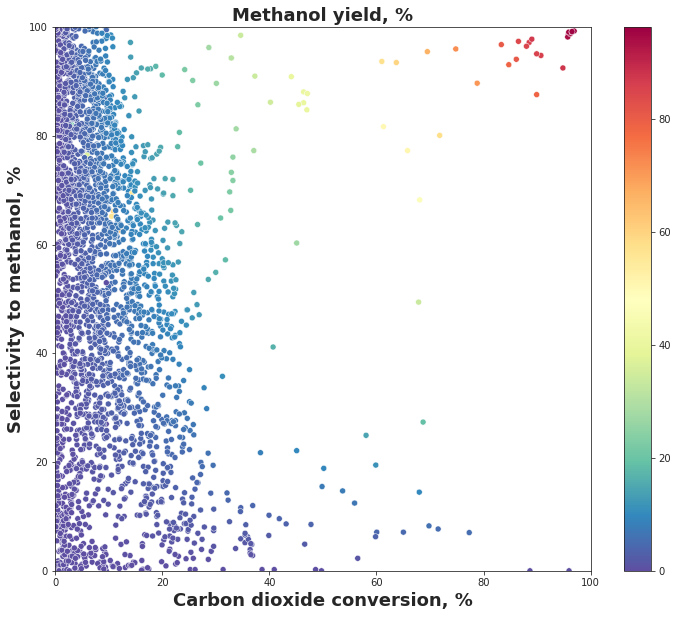

In [235]:
#Selectivity to methanol vs. conversion to co2
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))
norm = plt.Normalize(df['YMe'].min(), df['YMe'].max())
sm = plt.cm.ScalarMappable(cmap= 'Spectral_r', norm=norm)
sns.scatterplot(df['XCO2'],df['SMe'], hue= df['YMe'],palette = 'Spectral_r' ,ax= ax)
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_xlabel('Carbon dioxide conversion, %', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Selectivity to methanol, %', fontsize = 18, fontweight = 'bold')
ax.set_title('Methanol yield, %', fontsize = 18, fontweight = 'bold')
ax.get_legend().remove()
ax.figure.colorbar(sm)
#plt.tight_layout()
#plt.savefig('selconyield.png', dpi = 300)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


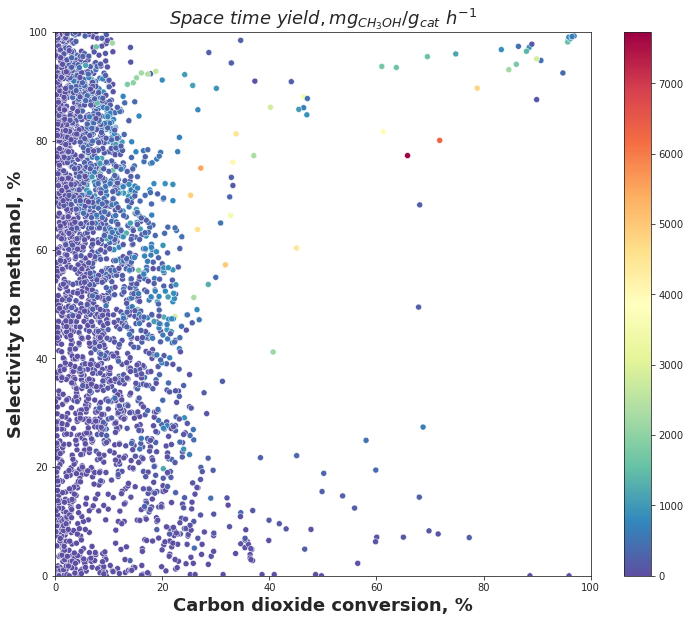

In [236]:
#Selectivity to methanol vs. conversion to co2
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))
norm = plt.Normalize(df['STY'].min(), df['STY'].max())
sm = plt.cm.ScalarMappable(cmap= 'Spectral_r', norm=norm)
sns.scatterplot(df['XCO2'],df['SMe'], hue= df['STY'],palette = 'Spectral_r' ,ax= ax)
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_xlabel('Carbon dioxide conversion, %', fontsize = 18, fontweight = 'bold')
ax.set_ylabel('Selectivity to methanol, %', fontsize = 18, fontweight = 'bold')
ax.set_title(r'$Space~time~yield, mg_{CH_{3}OH}/g_{cat}~h^{-1}$', fontsize = 18, fontweight = 'bold')
ax.get_legend().remove()
ax.figure.colorbar(sm)
#plt.tight_layout()
#plt.savefig('selconyield.png', dpi = 300)

In [237]:
df1 = df.drop(columns=['Pm'])

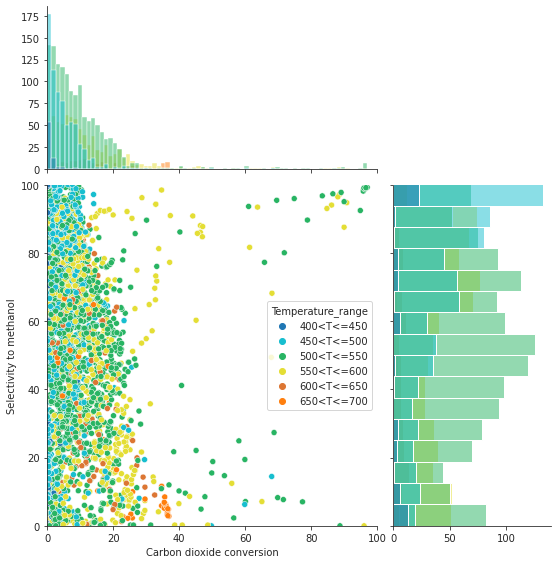

In [238]:
df1['Temperature_range'] = pd.cut(df['T'], bins = [400,450,500,550,600,650,700], labels = ['400<T<=450', '450<T<=500', '500<T<=550','550<T<=600','600<T<=650','650<T<=700'])
colors = ['#1f77b4','#17becf', '#28B463', '#E4DE35', '#DC7633','#ff7f0e']
sns.set_style("ticks")
g = sns.JointGrid(x=df['XCO2'], y=df['SMe'],hue = df1['Temperature_range'],palette = colors,xlim = (0,100),ylim = (0,100),height=8,ratio=2, space=0.1, 
                  marginal_ticks=True)
g.set_axis_labels(xlabel='Carbon dioxide conversion', ylabel='Selectivity to methanol')
g.plot(sns.scatterplot, sns.histplot)
#plt.tight_layout()
#plt.savefig('Temp.png', dpi= 300)

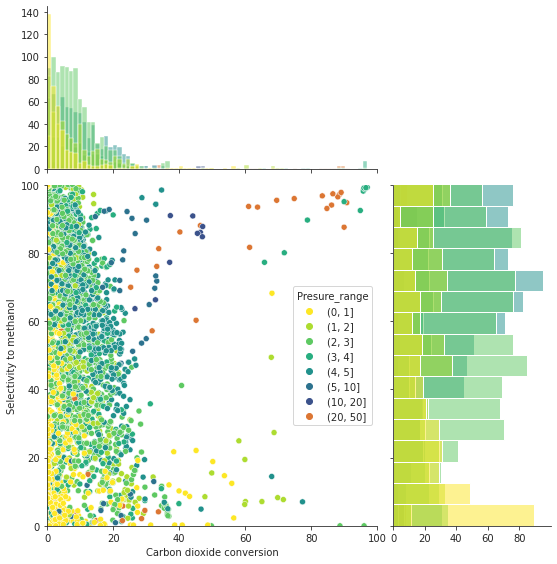

In [239]:
df1['Presure_range'] = pd.cut(df['P'], bins=[0,1,2,3,4,5,10,20,50])
#colors = ['#1f77b4','#17becf','#28B463','#E4DE35','#DC7633','#ff7f0e']
colors = ['#fde725','#addc30','#5ec962','#28ae80','#21918c','#2c728e','#3b528b','#DC7633']
sns.set_style("ticks")
g = sns.JointGrid(x=df['XCO2'], y=df['SMe'],hue = df1['Presure_range'],palette = colors,xlim = (0,100),ylim = (0,100),height=8,ratio=2, space=0.1, 
                  marginal_ticks=True)
g.set_axis_labels(xlabel='Carbon dioxide conversion', ylabel='Selectivity to methanol')
g.plot(sns.scatterplot, sns.histplot)
#plt.tight_layout()
#plt.savefig('Temp.png', dpi= 300)
#https://waldyrious.net/viridis-palette-generator/

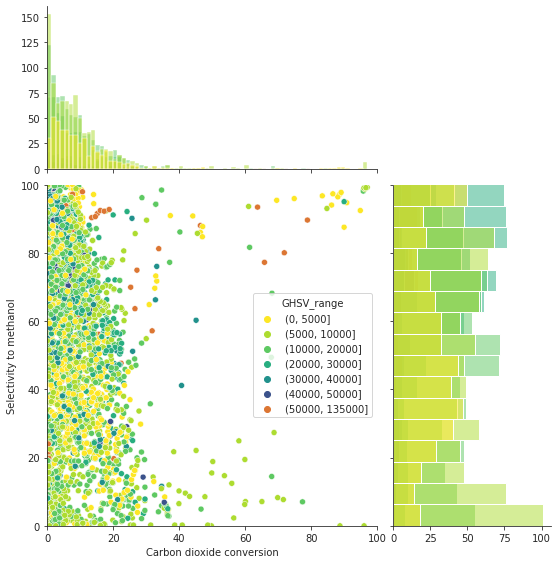

In [240]:
df1['GHSV_range'] = pd.cut(df['GHSV'], bins=[0,5000,10000,20000,30000,40000,50000,135000])
#colors = ['#1f77b4','#17becf','#28B463','#E4DE35','#DC7633','#ff7f0e']
colors = ['#fde725','#addc30','#5ec962','#28ae80','#21918c','#3b528b','#DC7633']
sns.set_style("ticks")
g = sns.JointGrid(x=df['XCO2'], y=df['SMe'],hue = df1['GHSV_range'],palette = colors,xlim = (0,100),ylim = (0,100),height=8,ratio=2, space=0.1, 
                  marginal_ticks=True)
g.set_axis_labels(xlabel='Carbon dioxide conversion', ylabel='Selectivity to methanol')
g.plot(sns.scatterplot, sns.histplot)
#plt.tight_layout()
#plt.savefig('Temp.png', dpi= 300)

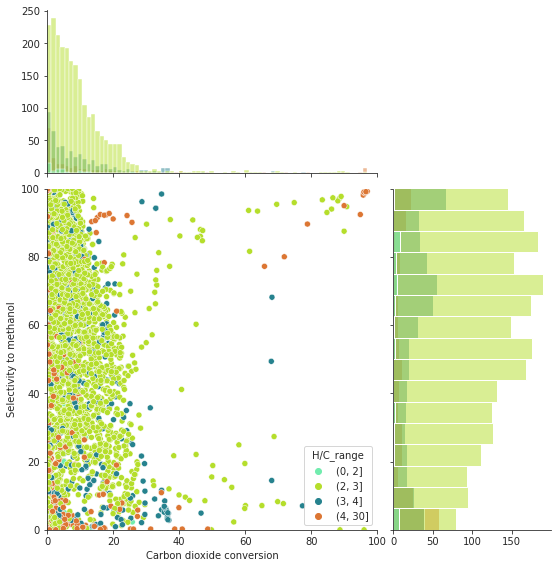

In [241]:
df1['H/C_range'] = pd.cut(df['H/C'], bins=[0,2,3,4,30])
#colors = ['#1f77b4','#17becf','#28B463','#E4DE35','#DC7633','#ff7f0e']
colors = ['#71ECAE','#b5de2b','#26828e','#DC7633']
sns.set_style("ticks")
g = sns.JointGrid(x=df['XCO2'], y=df['SMe'],hue = df1['H/C_range'],palette = colors,xlim = (0,100),ylim = (0,100),height=8,ratio=2, space=0.1, 
                  marginal_ticks=True)
g.set_axis_labels(xlabel='Carbon dioxide conversion', ylabel='Selectivity to methanol')
g.plot(sns.scatterplot, sns.histplot)
#plt.tight_layout()
#plt.savefig('Temp.png', dpi= 300)

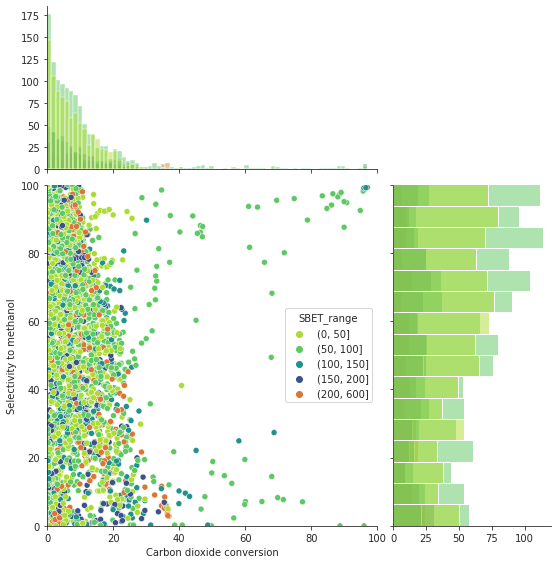

In [242]:
df1['SBET_range'] = pd.cut(df['SBET'], bins=[0,50,100,150,200,600])
#colors = ['#1f77b4','#17becf','#28B463','#E4DE35','#DC7633','#ff7f0e']
colors = ['#addc30','#5ec962','#21918c','#3b528b','#DC7633']
sns.set_style("ticks")
g = sns.JointGrid(x=df['XCO2'], y=df['SMe'],hue = df1['SBET_range'],palette = colors,xlim = (0,100),ylim = (0,100),height=8,ratio=2, space=0.1, 
                  marginal_ticks=True)
g.set_axis_labels(xlabel='Carbon dioxide conversion', ylabel='Selectivity to methanol')
g.plot(sns.scatterplot, sns.histplot)
#plt.tight_layout()
#plt.savefig('Temp.png', dpi= 300)

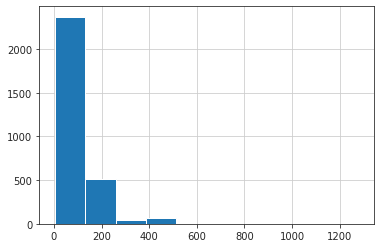

In [243]:
df['SBET'].hist()
plt.show()

In [244]:
df['Pm'] = df['Pm'].str.replace(' ','_')

In [245]:
df['Pm'].value_counts()

co-precipitation_method                                       831
incipient-wetness_impregnation_method                         561
wetness-impregnation_method                                   273
deposition-precipitation_method                               227
reverse_co-precipitation_method                               179
precipitation_method                                          132
solvothermal_method                                           109
hydrothermal_method                                           107
sol-gel_method                                                 65
commercial                                                     64
deposition_method                                              55
chemical_reduction_method                                      54
citrate_decomposition_method                                   44
pyrolysis_method                                               31
citric_acid_method                                             30
one-pot_hy

In [246]:
df = df.replace(['chemical_vapor_impregnation_method', 'he_surfactant-assisted_route_followed_by_the_reflux_method', 'chelating_method', 'colloidal_crystal_template_method', 'evaporation-induced_self-assembly_method', 'precipitation-reduction_method', 'atomic_layer_deposition ', 'calcination', 'complexation_by_citric_acid', 'flame_spray_pyrolysis_method', 'double_co-impregnation_', 'precipitation_and_reflux_digestion_method', 'impregnation-precipitation_method', 'solid-state_reaction_method '],['others', 'others', 'others', 'others', 'others', 'others', 'others', 'others', 'others', 'others', 'others', 'others', 'others', 'others'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


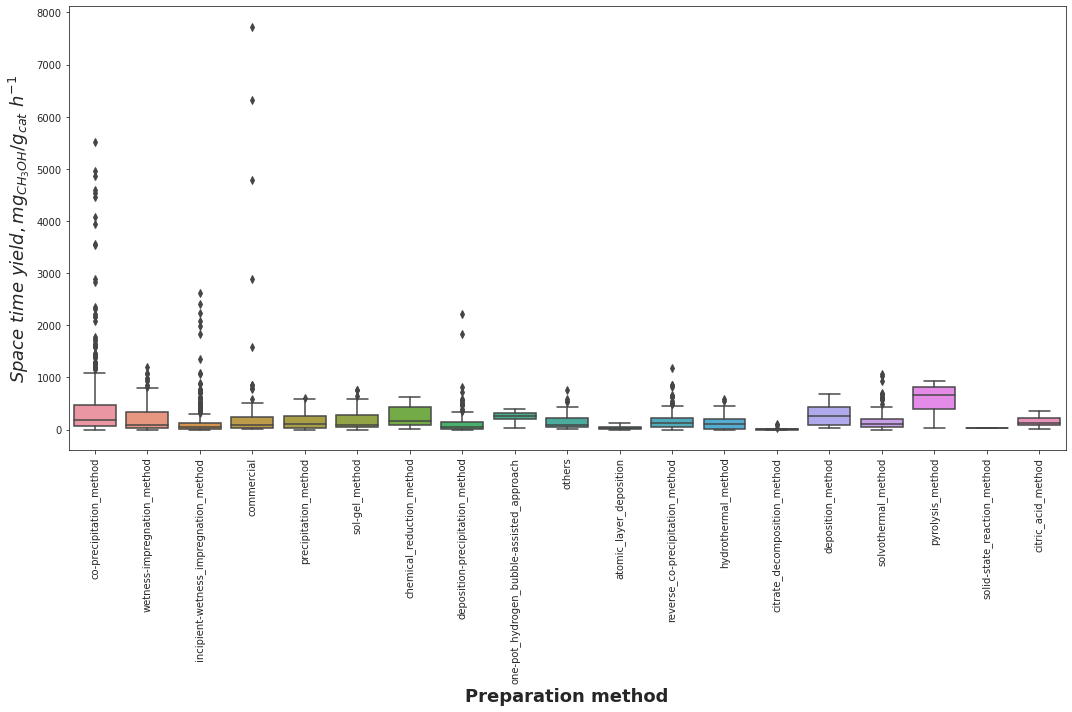

In [247]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10))
sns.boxplot(df['Pm'],df['STY'], ax = ax)
ax.set_ylabel(r'$Space~time~yield, mg_{CH_{3}OH}/g_{cat}~h^{-1}$', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Preparation method', fontsize = 18, fontweight = 'bold')
plt.xticks(rotation=90)
plt.tight_layout()


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


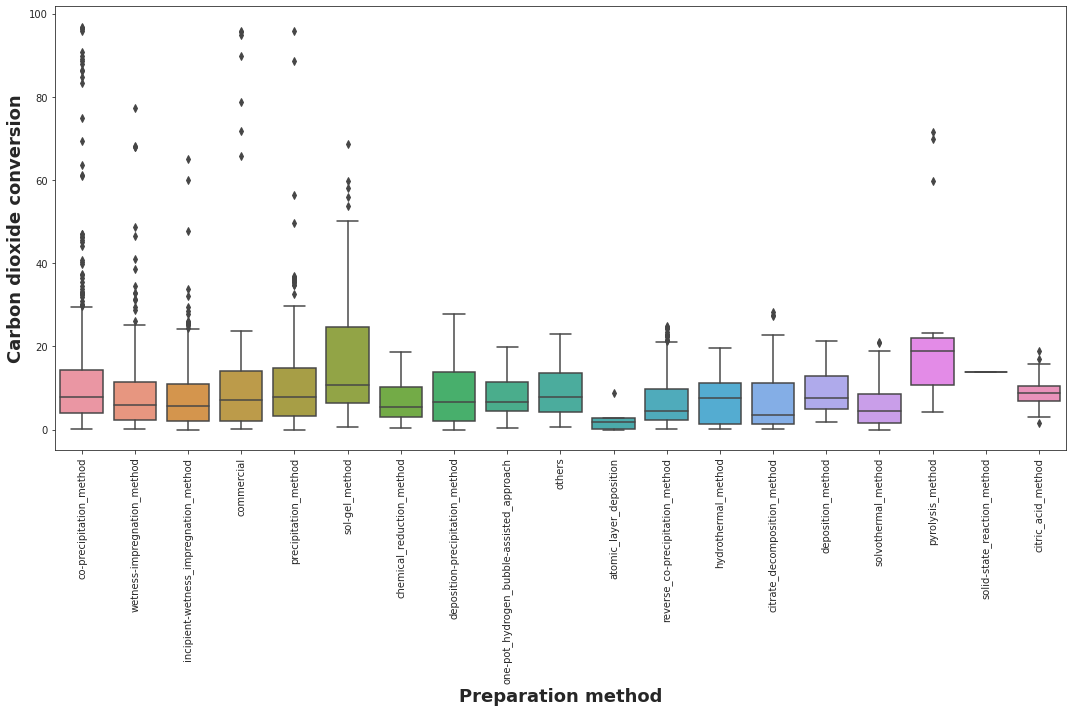

In [248]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10))
sns.boxplot(df['Pm'],df['XCO2'], ax = ax)
ax.set_ylabel('Carbon dioxide conversion', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Preparation method', fontsize = 18, fontweight = 'bold')
plt.xticks(rotation=90)
plt.tight_layout()


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


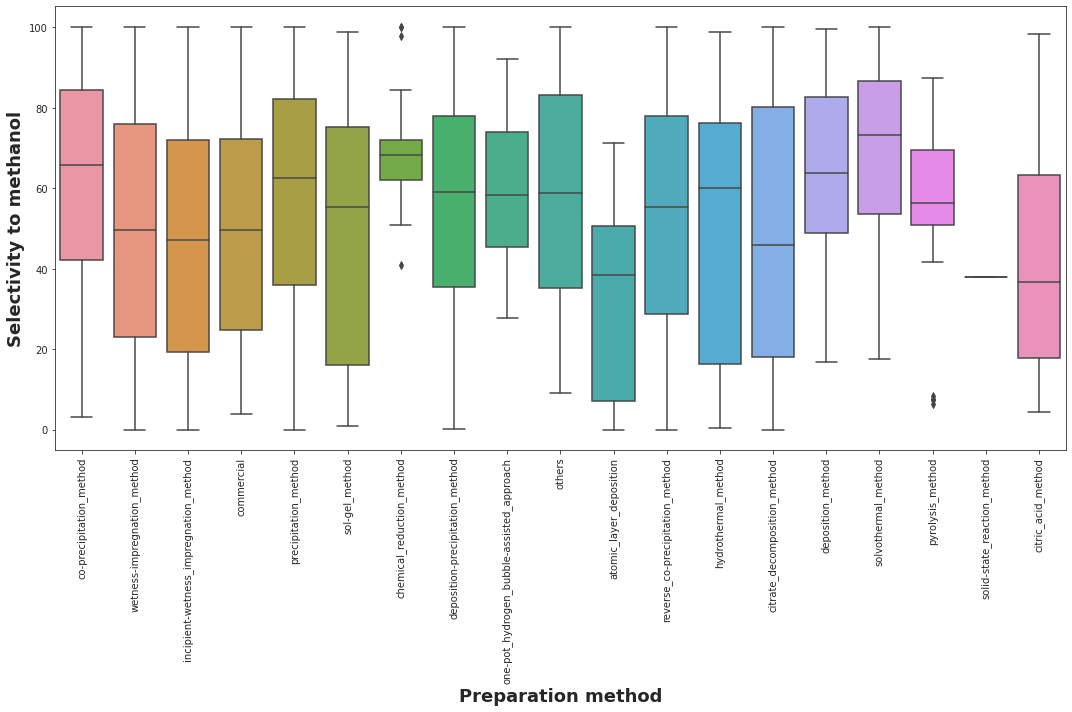

In [249]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10))
sns.boxplot(df['Pm'],df['SMe'], ax = ax)
ax.set_ylabel('Selectivity to methanol', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Preparation method', fontsize = 18, fontweight = 'bold')
plt.xticks(rotation=90)
plt.tight_layout()


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


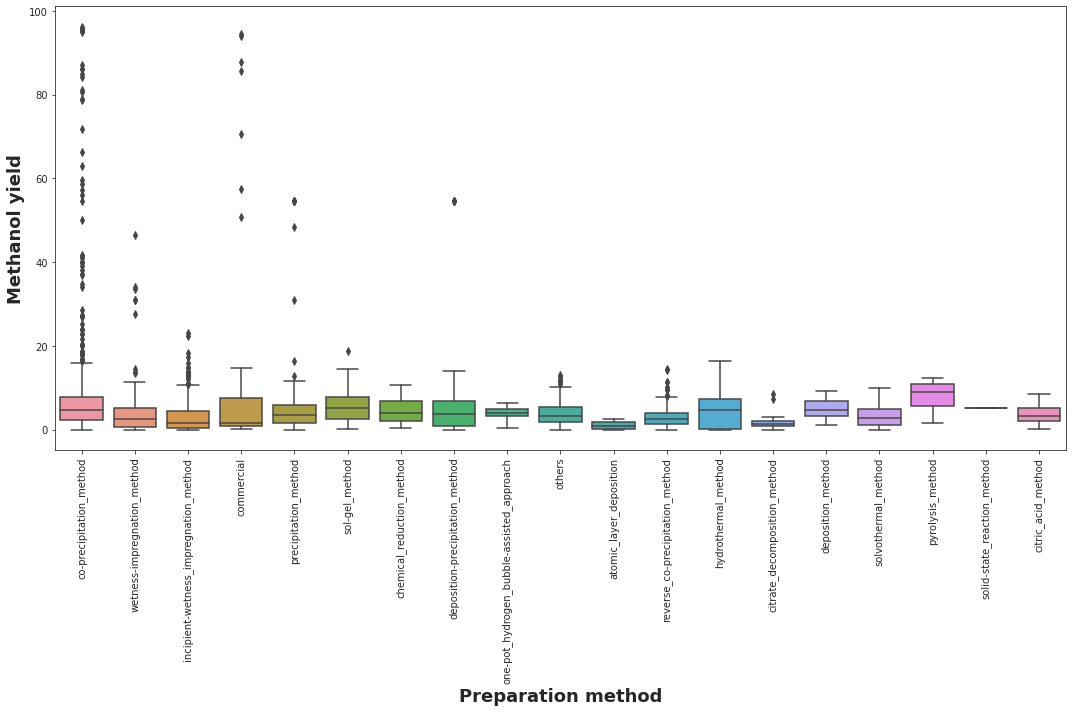

In [250]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15,10))
sns.boxplot(df['Pm'],df['YMe'], ax = ax)
ax.set_ylabel('Methanol yield', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Preparation method', fontsize = 18, fontweight = 'bold')
plt.xticks(rotation=90)
plt.tight_layout()


# **DATA DISTRIBUTION**

In [251]:
df1 = df.drop(columns = ['Pm'])

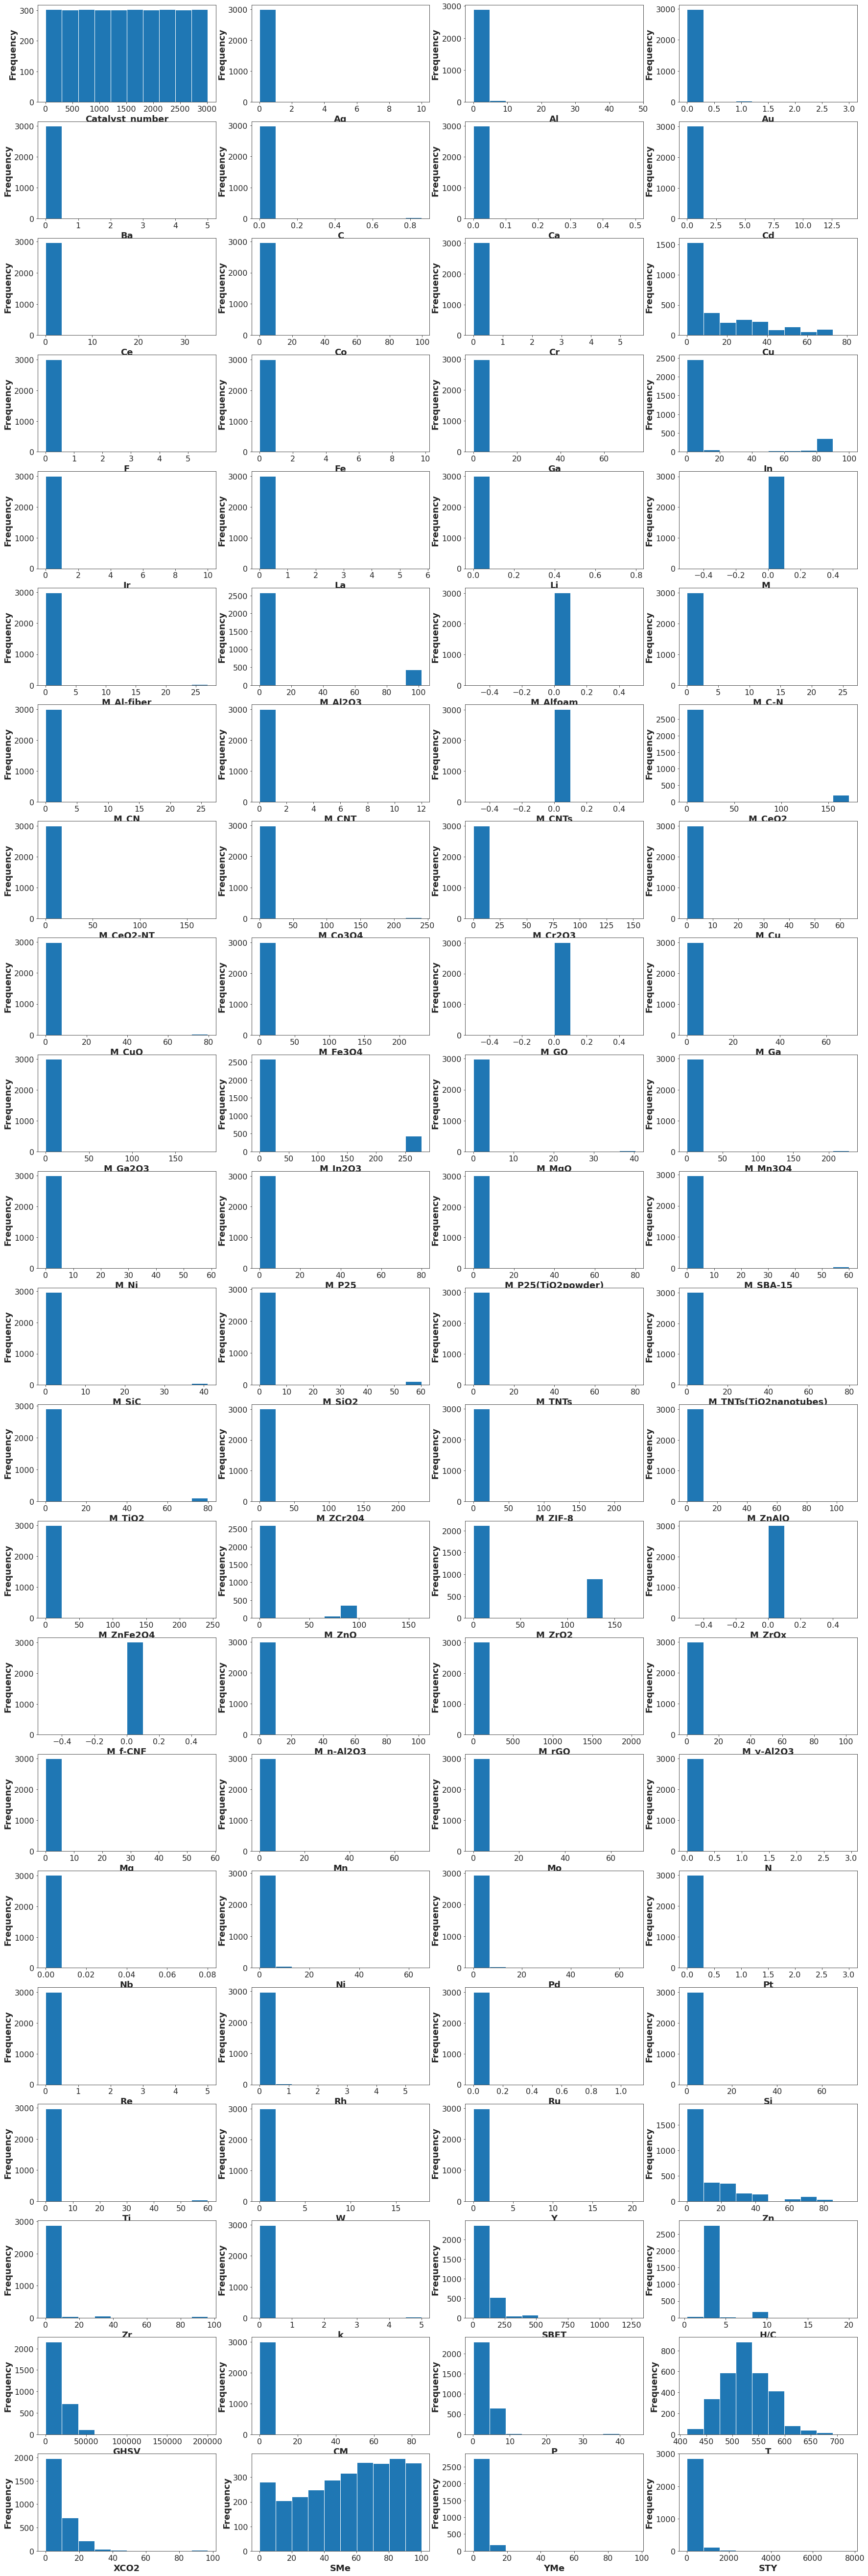

In [252]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df1:
  sub = fig.add_subplot(23,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df1[column].plot(kind = 'hist')
  i = i + 1

# **NUMERICAL DATA TRANSFORMATION**

## **ROOT SQRT TRANSFORMATION**

In [253]:
df_tsq= np.sqrt(df[['Ag', 'Al', 'Au', 'Ba', 'C', 'Ca', 'Cd', 'Ce', 'Co',
       'Cr', 'Cu', 'Fe', 'Ga', 'In', 'Ir', 'La', 'M_Al-fiber', 'M_Al2O3',
       'M_Alfoam', 'M_C-N', 'M_CN', 'M_CNT', 'M_CeO2', 'M_CeO2-NT', 'M_Cr2O3',
       'M_Cu', 'M_Fe3O4', 'M_GO', 'M_Ga', 'M_Ga2O3', 'M_In2O3', 'M_MgO',
       'M_Ni', 'M_P25', 'M_P25(TiO2powder)', 'M_SBA-15', 'M_SiO2', 'M_TNTs',
       'M_TNTs(TiO2nanotubes)', 'M_TiO2', 'M_ZCr204', 'M_ZnFe2O4', 'M_ZnO',
       'M_ZrO2', 'M_ZrOx', 'M_f-CNF', 'M_n-Al2O3', 'M_rGO', 'M_γ-Al2O3', 'Mg',
       'Mn', 'Mo', 'Nb', 'Ni', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 'Si', 'Ti', 'W',
       'Y', 'Zn', 'Zr', 'k', 'SBET', 'H/C', 'GHSV', 'CM', 'P', 'T',
       'XCO2', 'SMe', 'YMe', 'STY']])

In [254]:
print(df_tsq)

       Ag   Al   Au   Ba    C   Ca   Cd   Ce   Co   Cr  ...      SBET  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
3010  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   
3011  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   
3012  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   
3013  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   
3014  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  9.841386   

           H/C       GHSV        CM         P          T      XCO2        SMe  \
0     1.732051  80.625939  0.547723  2.000

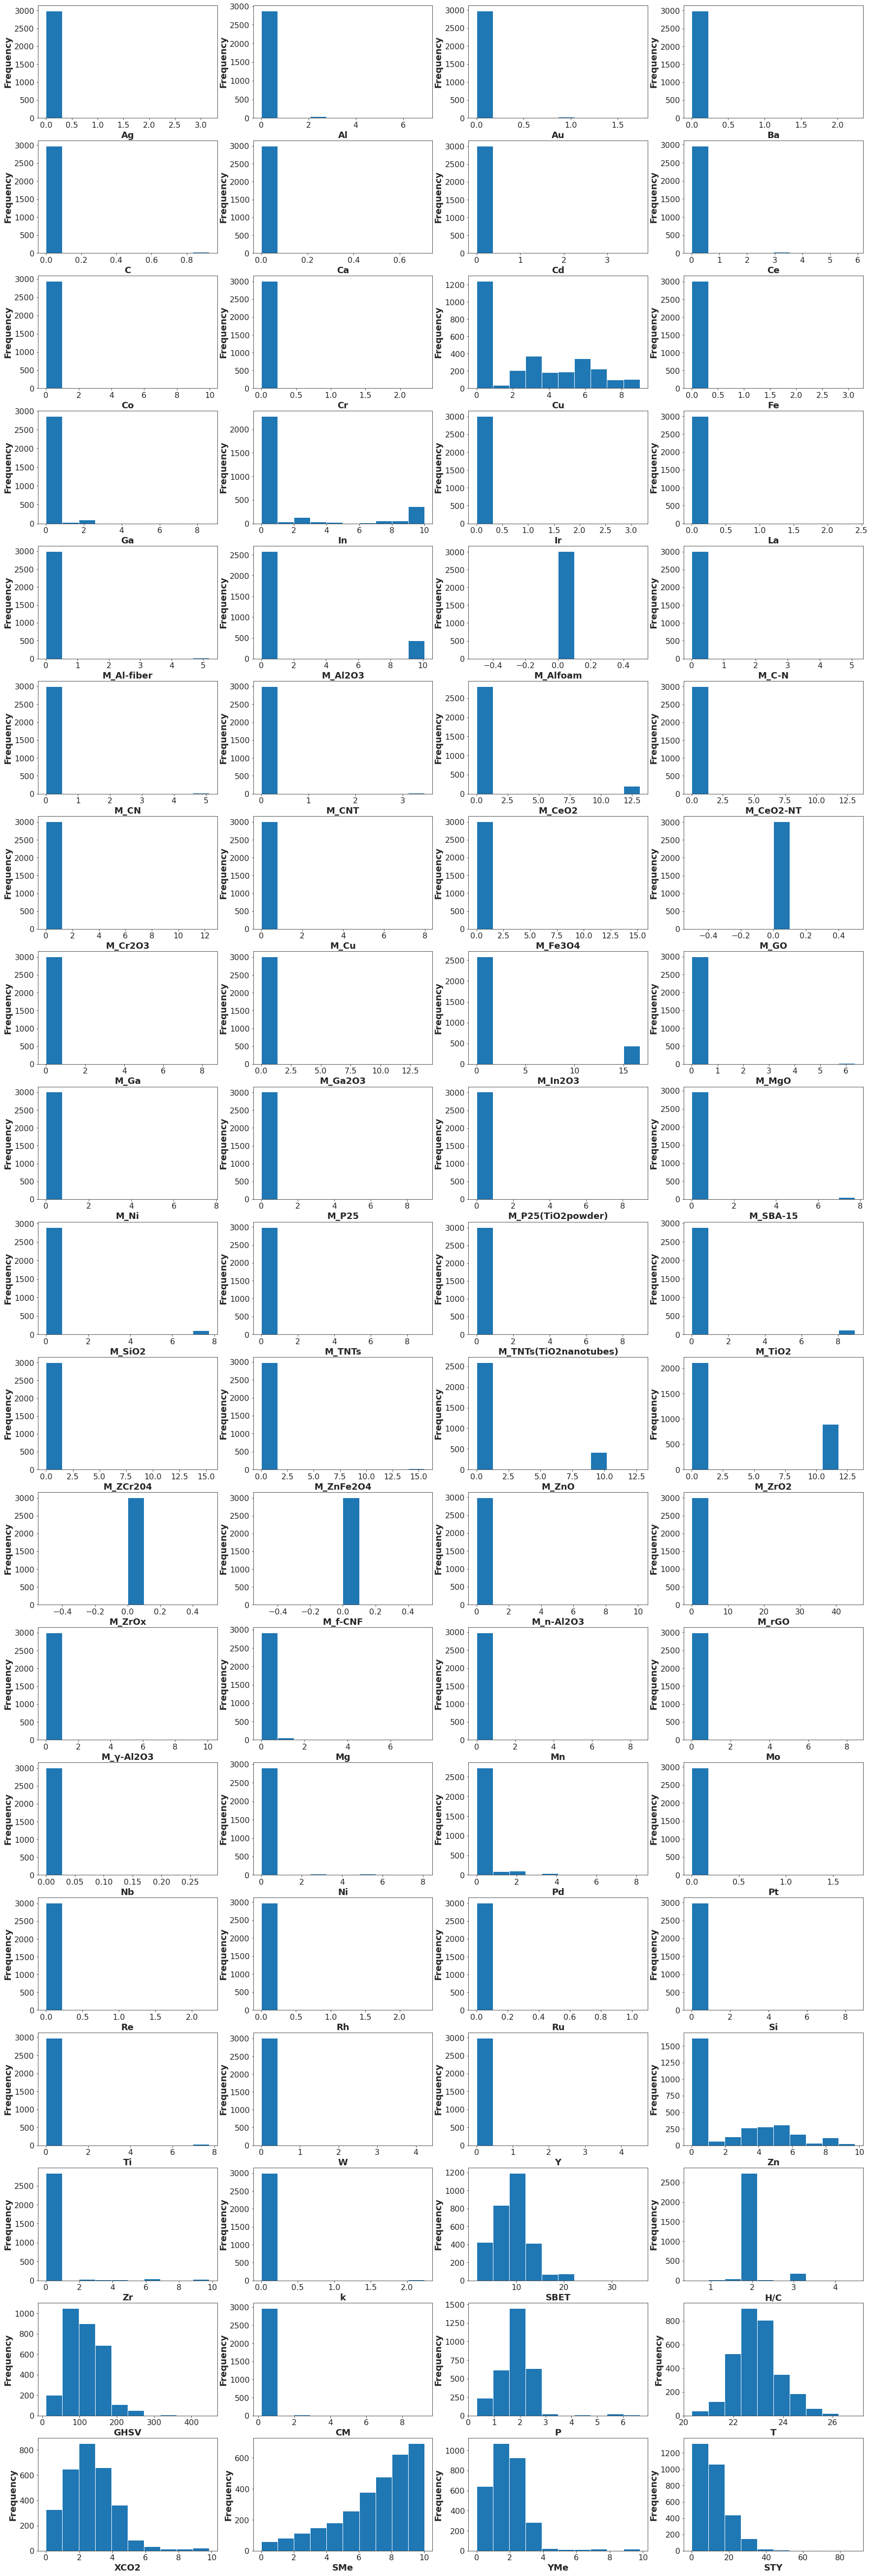

In [255]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df_tsq:
  sub = fig.add_subplot(20,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df_tsq[column].plot(kind = 'hist')
  i = i + 1

In [256]:
#using transform from sklearn
transformer_sq = FunctionTransformer(np.sqrt)
df_tsq1 = transformer_sq.transform(df[['Ag', 'Al', 'Au', 'Ba', 'C', 'Ca', 'Cd', 'Ce', 'Co',
       'Cr', 'Cu', 'Fe', 'Ga', 'In', 'Ir', 'La', 'M_Al-fiber', 'M_Al2O3',
       'M_Alfoam', 'M_C-N', 'M_CN', 'M_CNT', 'M_CeO2', 'M_CeO2-NT', 'M_Cr2O3',
       'M_Cu', 'M_Fe3O4', 'M_GO', 'M_Ga', 'M_Ga2O3', 'M_In2O3', 'M_MgO',
       'M_Ni', 'M_P25', 'M_P25(TiO2powder)', 'M_SBA-15', 'M_SiO2', 'M_TNTs',
       'M_TNTs(TiO2nanotubes)', 'M_TiO2', 'M_ZCr204', 'M_ZnFe2O4', 'M_ZnO',
       'M_ZrO2', 'M_ZrOx', 'M_f-CNF', 'M_n-Al2O3', 'M_rGO', 'M_γ-Al2O3', 'Mg',
       'Mn', 'Mo', 'Nb', 'Ni', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 'Si', 'Ti', 'W',
       'Y', 'Zn', 'Zr', 'k', 'SBET', 'H/C', 'GHSV', 'CM', 'P', 'T',
       'XCO2', 'SMe', 'YMe', 'STY']])


## **CUBE TRANSFORMATION**

In [257]:
transformer_cb = FunctionTransformer(np.cbrt)
df_tcb = transformer_cb.transform(df[['Ag', 'Al', 'Au', 'Ba', 'C', 'Ca', 'Cd', 'Ce', 'Co',
       'Cr', 'Cu', 'Fe', 'Ga', 'In', 'Ir', 'La', 'M_Al-fiber', 'M_Al2O3',
       'M_Alfoam', 'M_C-N', 'M_CN', 'M_CNT', 'M_CeO2', 'M_CeO2-NT', 'M_Cr2O3',
       'M_Cu', 'M_Fe3O4', 'M_GO', 'M_Ga', 'M_Ga2O3', 'M_In2O3', 'M_MgO',
       'M_Ni', 'M_P25', 'M_P25(TiO2powder)', 'M_SBA-15', 'M_SiO2', 'M_TNTs',
       'M_TNTs(TiO2nanotubes)', 'M_TiO2', 'M_ZCr204', 'M_ZnFe2O4', 'M_ZnO',
       'M_ZrO2', 'M_ZrOx', 'M_f-CNF', 'M_n-Al2O3', 'M_rGO', 'M_γ-Al2O3', 'Mg',
       'Mn', 'Mo', 'Nb', 'Ni', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 'Si', 'Ti', 'W',
       'Y', 'Zn', 'Zr', 'k', 'SBET', 'H/C', 'GHSV', 'CM', 'P', 'T',
       'XCO2', 'SMe', 'YMe', 'STY']])


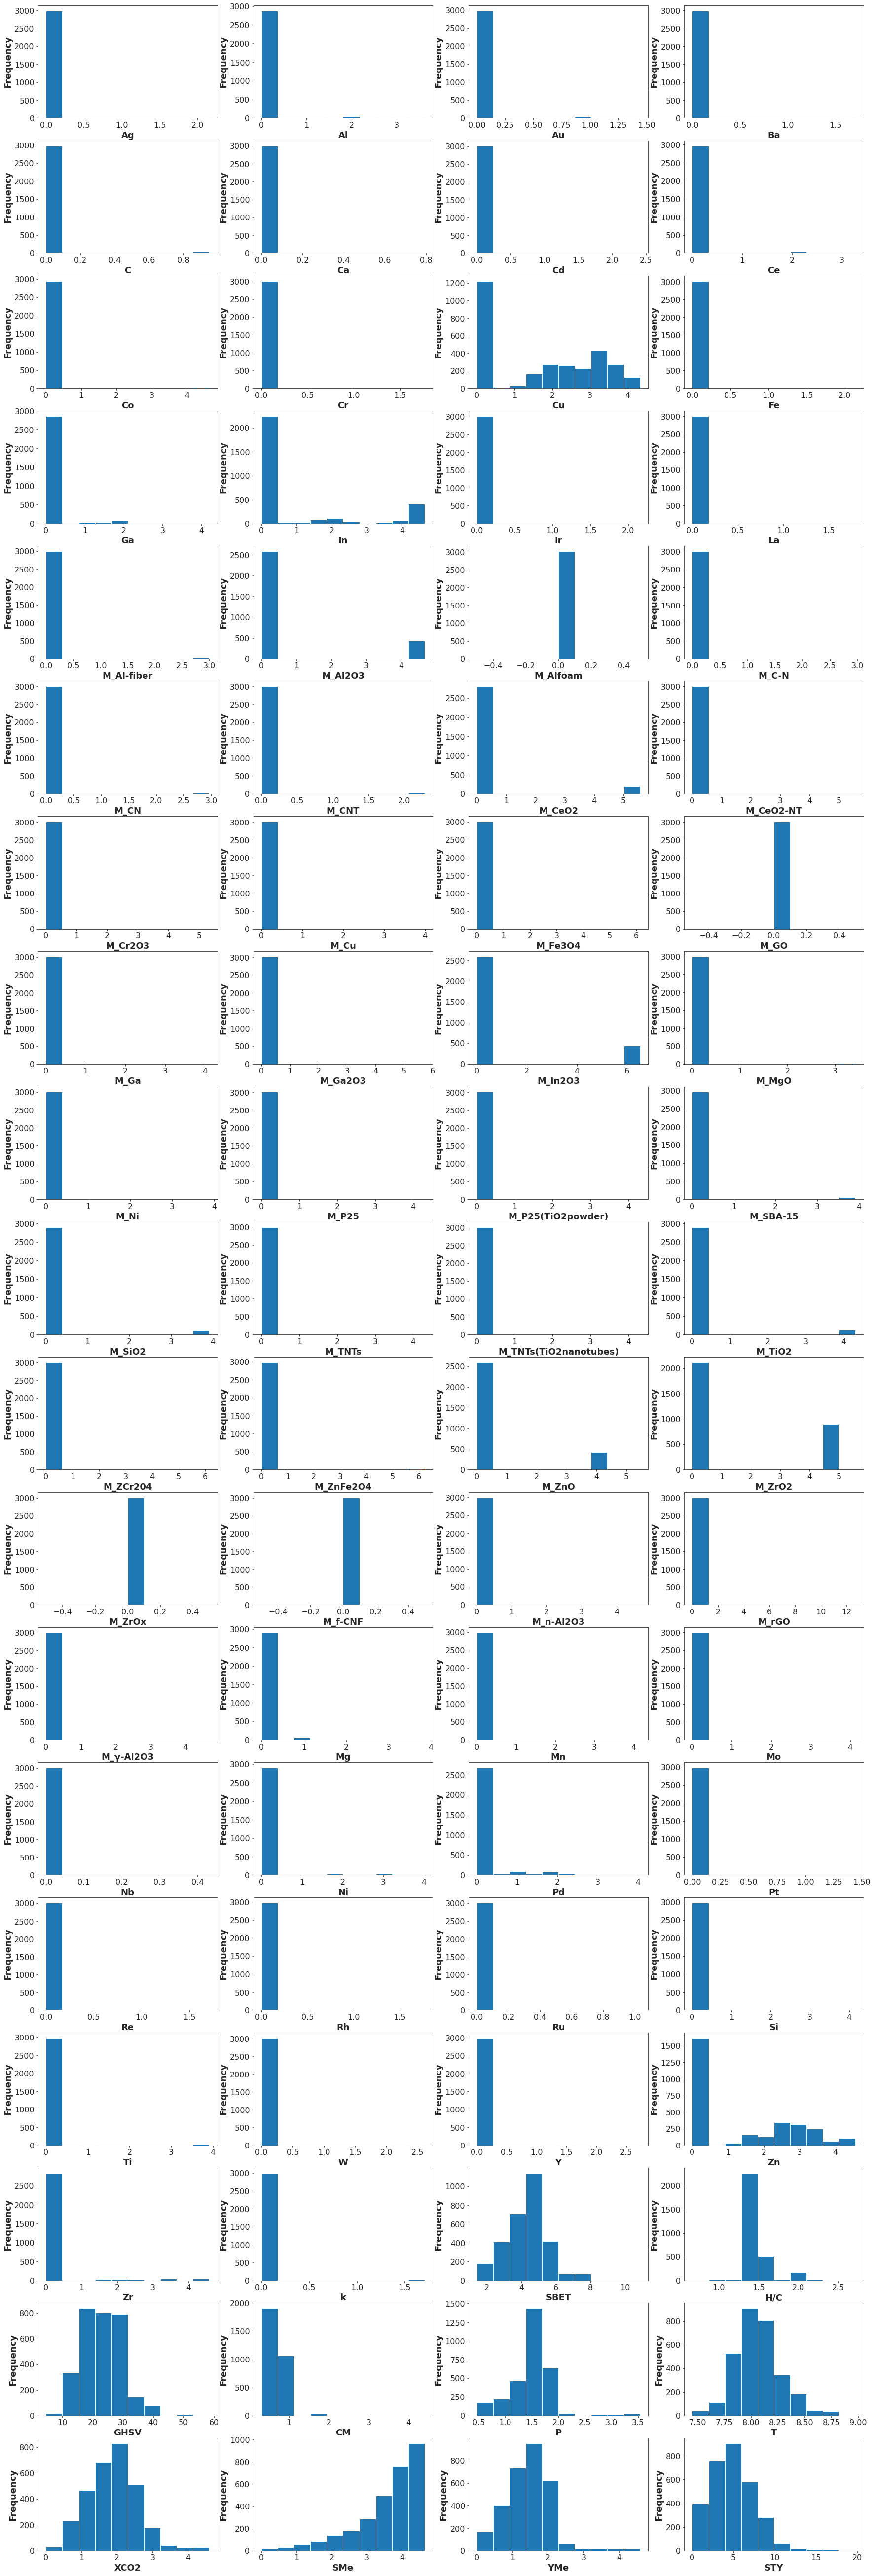

In [258]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df_tcb:
  sub = fig.add_subplot(20,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df_tcb[column].plot(kind = 'hist')
  i = i + 1

## **POWER TRANSFORMATION **

In [259]:
transformer_pt = FunctionTransformer(lambda x: np.power(x, 0.34))
df_pt = transformer_pt.transform(df[['Ag', 'Al', 'Au', 'Ba', 'C', 'Ca', 'Cd', 'Ce', 'Co',
       'Cr', 'Cu', 'Fe', 'Ga', 'In', 'Ir', 'La', 'M_Al-fiber', 'M_Al2O3',
       'M_Alfoam', 'M_C-N', 'M_CN', 'M_CNT', 'M_CeO2', 'M_CeO2-NT', 'M_Cr2O3',
       'M_Cu', 'M_Fe3O4', 'M_GO', 'M_Ga', 'M_Ga2O3', 'M_In2O3', 'M_MgO',
       'M_Ni', 'M_P25', 'M_P25(TiO2powder)', 'M_SBA-15', 'M_SiO2', 'M_TNTs',
       'M_TNTs(TiO2nanotubes)', 'M_TiO2', 'M_ZCr204', 'M_ZnFe2O4', 'M_ZnO',
       'M_ZrO2', 'M_ZrOx', 'M_f-CNF', 'M_n-Al2O3', 'M_rGO', 'M_γ-Al2O3', 'Mg',
       'Mn', 'Mo', 'Nb', 'Ni', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 'Si', 'Ti', 'W',
       'Y', 'Zn', 'Zr', 'k', 'SBET', 'H/C', 'GHSV', 'CM', 'P', 'T',
       'XCO2', 'SMe', 'YMe', 'STY']])

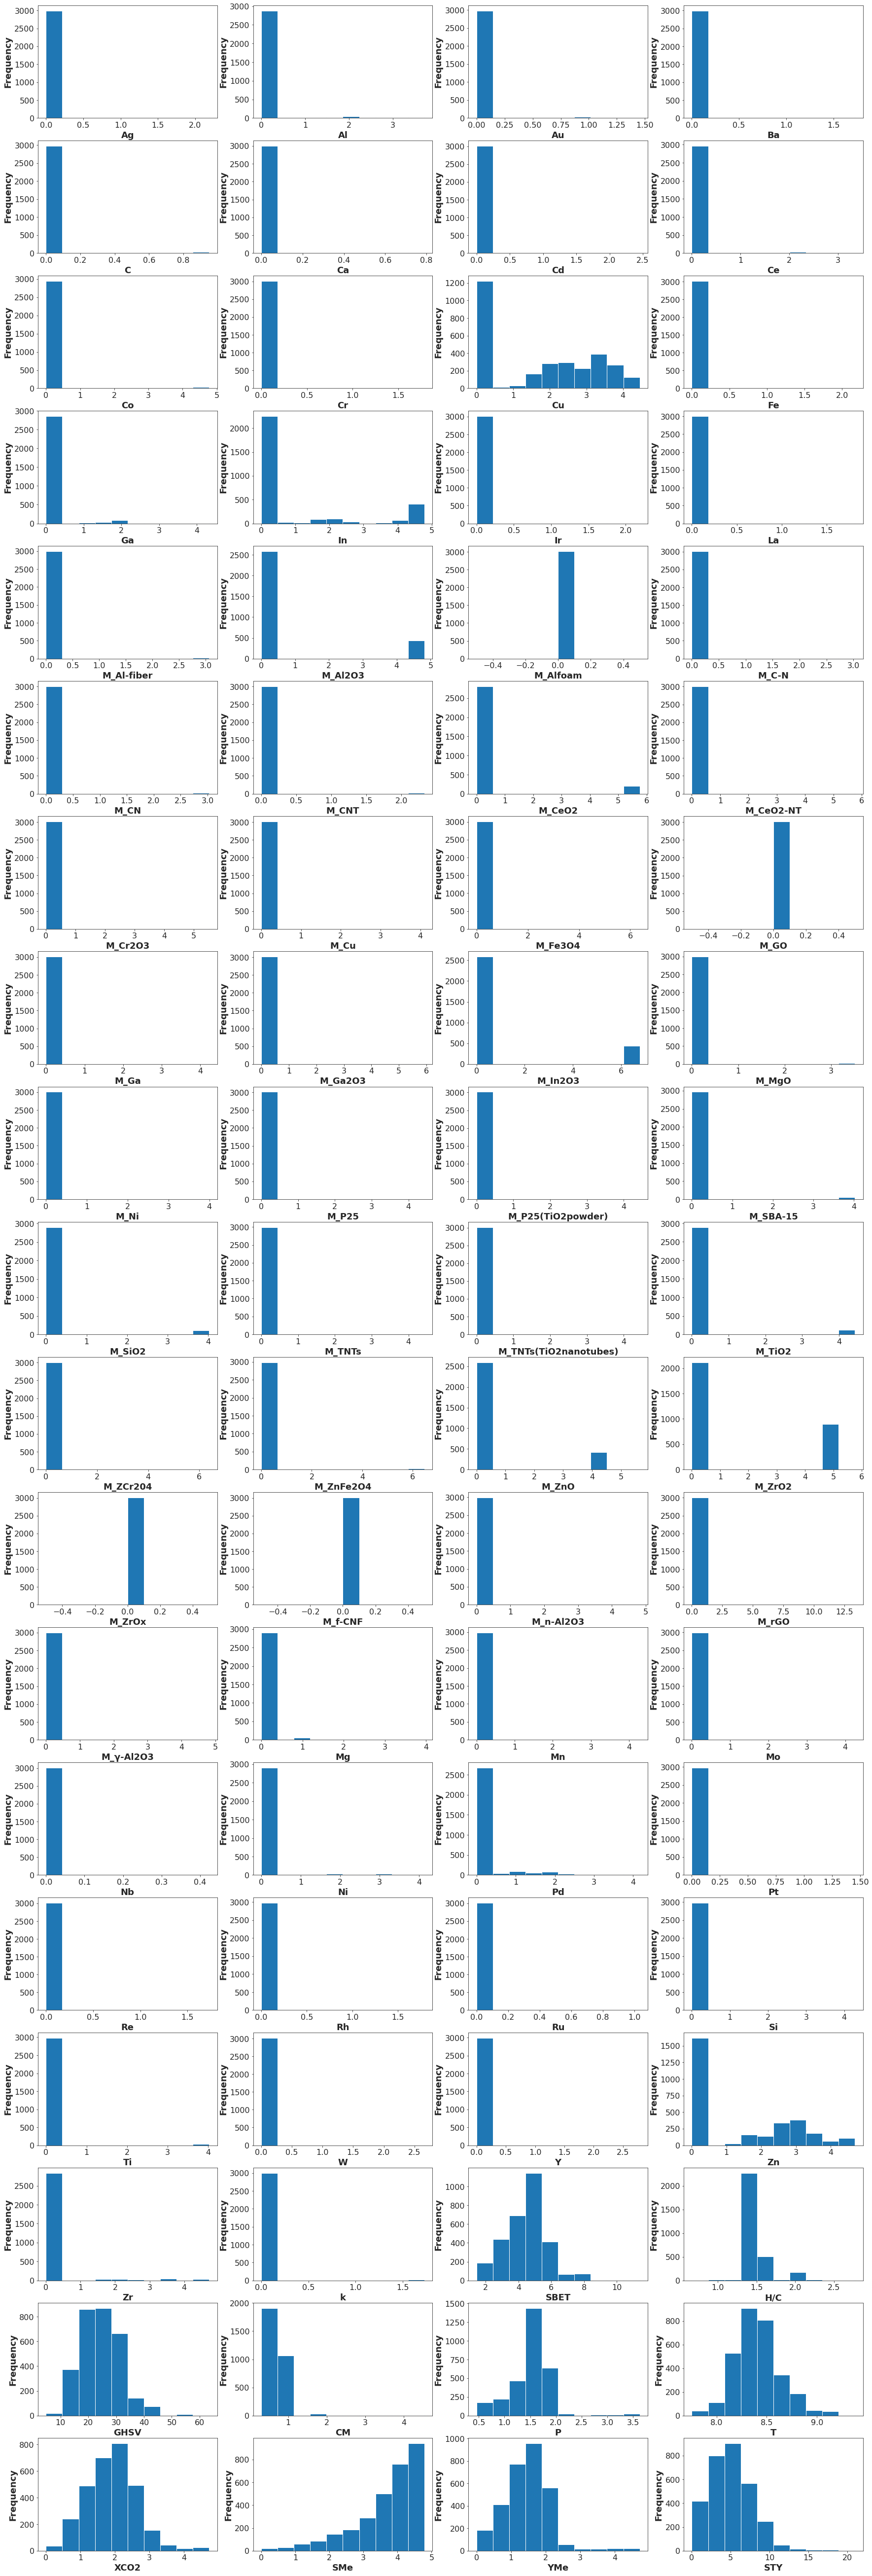

In [260]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df_pt:
  sub = fig.add_subplot(20,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df_pt[column].plot(kind = 'hist')
  i = i + 1

## **WORKING WITH OUTLIERS**

**A. ENGINEERING APPROACH**

In [261]:
#df_out1 eliminate P<= 10 MPa
df_out1 = df[df['P']<=10]

In [262]:
df_out1.shape

(2969, 89)

In [263]:
# df_out2 delete XCO2 <= 40%
df_out2 = df_out1[df_out1['XCO2']<=40]

In [264]:
df_out2.shape

(2929, 89)

In [265]:
# df_out3 delete YMe <= 20%
df_out3 = df_out2[df_out2['YMe']<=20]

In [266]:
df_out3.shape

(2896, 89)

In [267]:
# df_out4 delete STY <= 2000
df_out4 = df_out3[df_out3['STY']<=1000]

In [268]:
df_out4.shape

(2840, 89)

In [269]:
# df_out4 delete CM <= 1 g
df_out5 = df_out4[df_out4['CM']<=1]

In [270]:
df_Fout5 = df_out5.drop(columns = ['Pm'])

In [271]:
df_Fout5.shape

(2797, 88)

**A.ENCODING CATEGORICAL VARIABLES**


In [272]:
encoder = OneHotEncoder()
coding = encoder.fit_transform(df_out5[["Pm"]])
df_he = pd.DataFrame(coding.toarray(), columns=encoder.categories_)
df_he.head()

atomic_layer_deposition chemical_reduction_method  \
0                     0.0                       0.0   
1                     0.0                       0.0   
2                     0.0                       0.0   
3                     0.0                       0.0   
4                     0.0                       0.0   

  citrate_decomposition_method citric_acid_method co-precipitation_method  \
0                          0.0                0.0                     1.0   
1                          0.0                0.0                     1.0   
2                          0.0                0.0                     1.0   
3                          0.0                0.0                     1.0   
4                          0.0                0.0                     1.0   

  commercial deposition-precipitation_method deposition_method  \
0        0.0                             0.0               0.0   
1        0.0                             0.0               0.0   
2        0.0                             0.0               0.0   
3        0.0                             0.0               0.0   
4        0.0                             0.0               0.0   

  hydrothermal_method incipient-wetness_impregnation_method  \
0                 0.0                                   0.0   
1                 0.0                                   0.0   
2                 0.0                                   0.0   
3                 0.0                                   0.0   
4                 0.0                                   0.0   

  one-pot_hydrogen_bubble-assisted_approach others precipitation_method  \
0                                       0.0    0.0                  0.0   
1                                       0.0    0.0                  0.0   
2                                       0.0    0.0                  0.0   
3                                       0.0    0.0                  0.0   
4                                       0.0    0.0                  0.0   

  pyrolysis_method reverse_co-precipitation_method sol-gel_method  \
0              0.0                             0.0            0.0   
1              0.0                             0.0            0.0   
2              0.0                             0.0            0.0   
3              0.0                             0.0            0.0   
4              0.0                             0.0            0.0   

  solid-state_reaction_method solvothermal_method wetness-impregnation_method  \
0                         0.0                 0.0                         0.0   
1                         0.0                 0.0                         0.0   
2                         0.0                 0.0                         0.0   
3                         0.0                 0.0                         0.0   
4                         0.0                 0.0                         0.0   

   NaN  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0

 **A.RAW DISTRIBUTION**

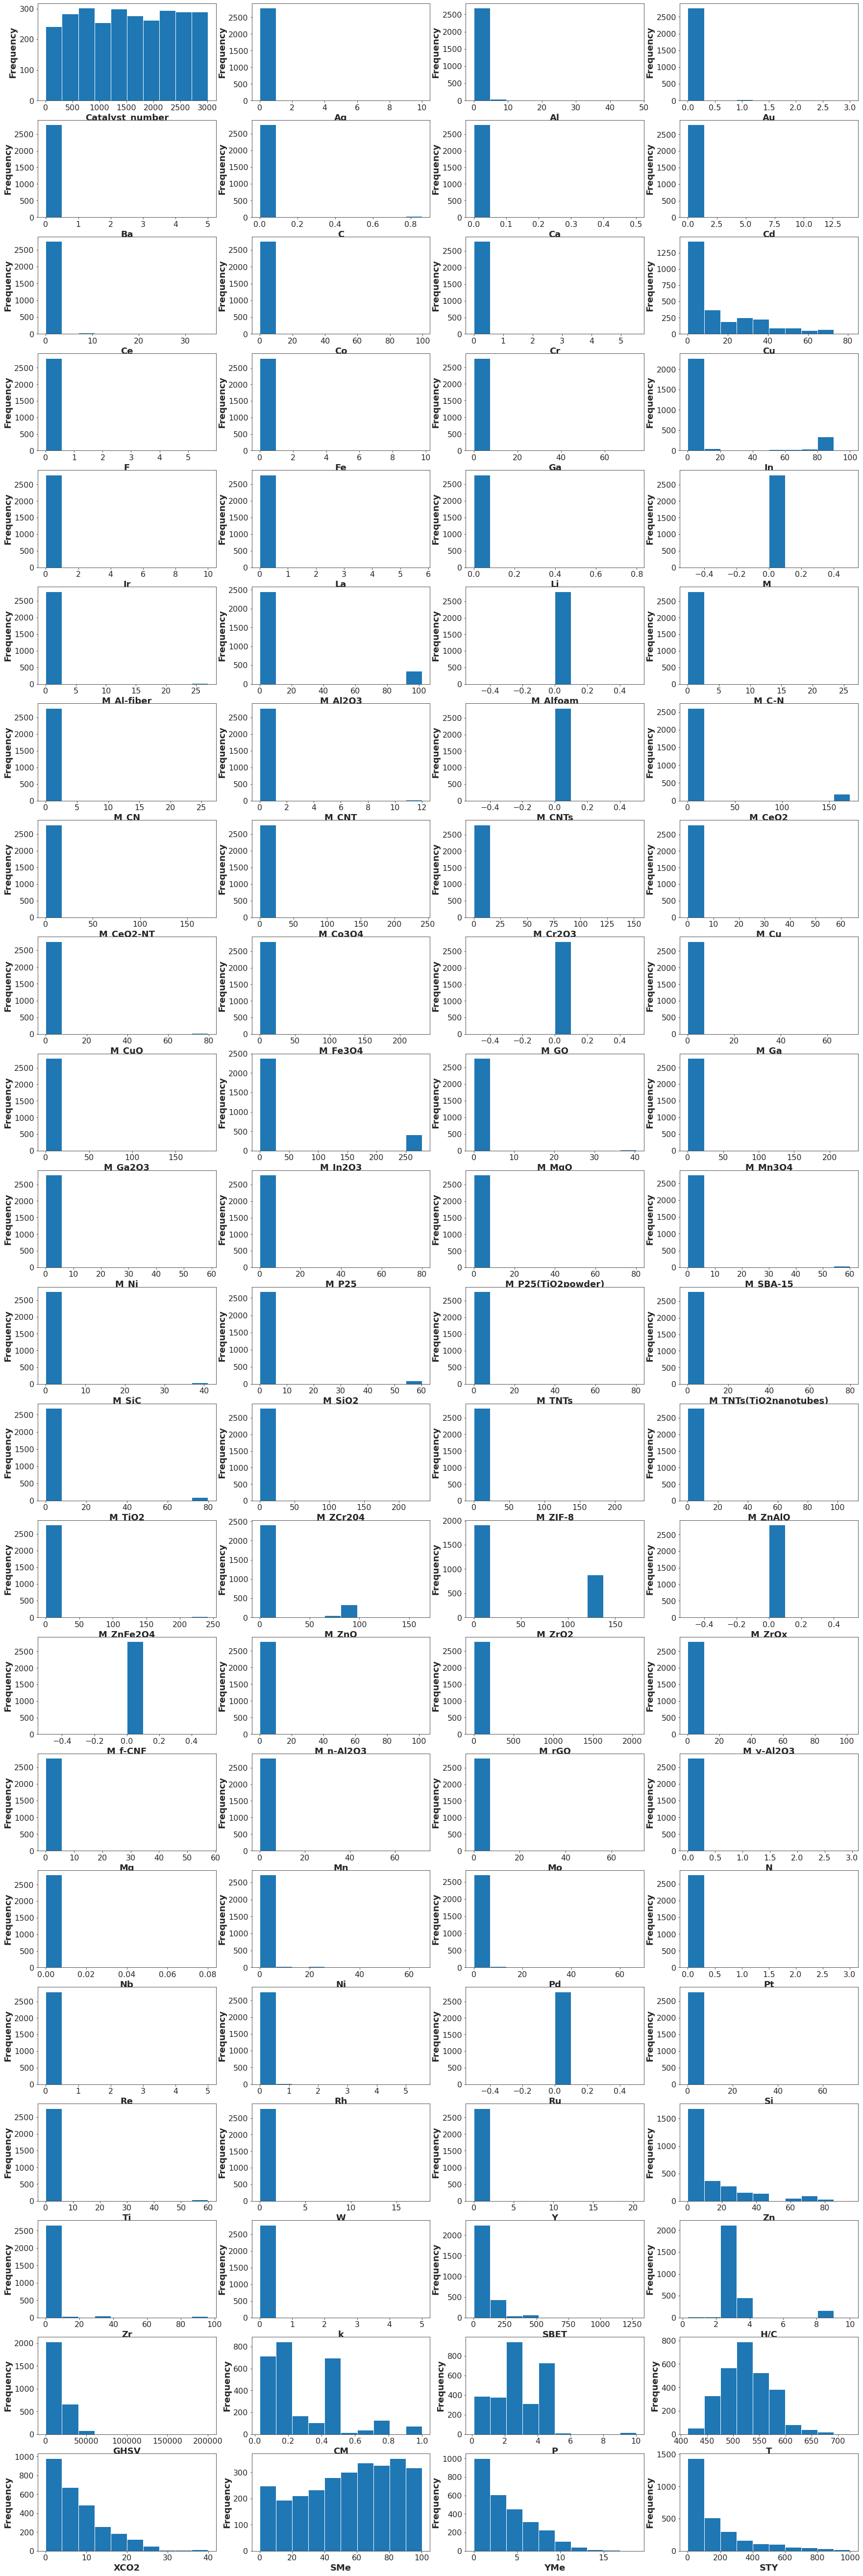

In [273]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df_Fout5:
  sub = fig.add_subplot(23,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df_Fout5[column].plot(kind = 'hist')
  i = i + 1

**A.ROOT SQRT TRANSFORMATION**

In [274]:
df_5tsq= np.sqrt(df_Fout5[['Ag', 'Al', 'Au', 'Ba', 'C', 'Ca', 'Cd', 'Ce', 'Co',
       'Cr', 'Cu', 'Fe', 'Ga', 'In', 'Ir', 'La', 'M_Al-fiber', 'M_Al2O3',
       'M_Alfoam', 'M_C-N', 'M_CN', 'M_CNT', 'M_CeO2', 'M_CeO2-NT', 'M_Cr2O3',
       'M_Cu', 'M_Fe3O4', 'M_GO', 'M_Ga', 'M_Ga2O3', 'M_In2O3', 'M_MgO',
       'M_Ni', 'M_P25', 'M_P25(TiO2powder)', 'M_SBA-15', 'M_SiO2', 'M_TNTs',
       'M_TNTs(TiO2nanotubes)', 'M_TiO2', 'M_ZCr204', 'M_ZnFe2O4', 'M_ZnO',
       'M_ZrO2', 'M_ZrOx', 'M_f-CNF', 'M_n-Al2O3', 'M_rGO', 'M_γ-Al2O3', 'Mg',
       'Mn', 'Mo', 'Nb', 'Ni', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 'Si', 'Ti', 'W',
       'Y', 'Zn', 'Zr', 'k', 'SBET', 'H/C', 'GHSV', 'CM', 'P', 'T',
       'XCO2', 'SMe', 'YMe', 'STY']])

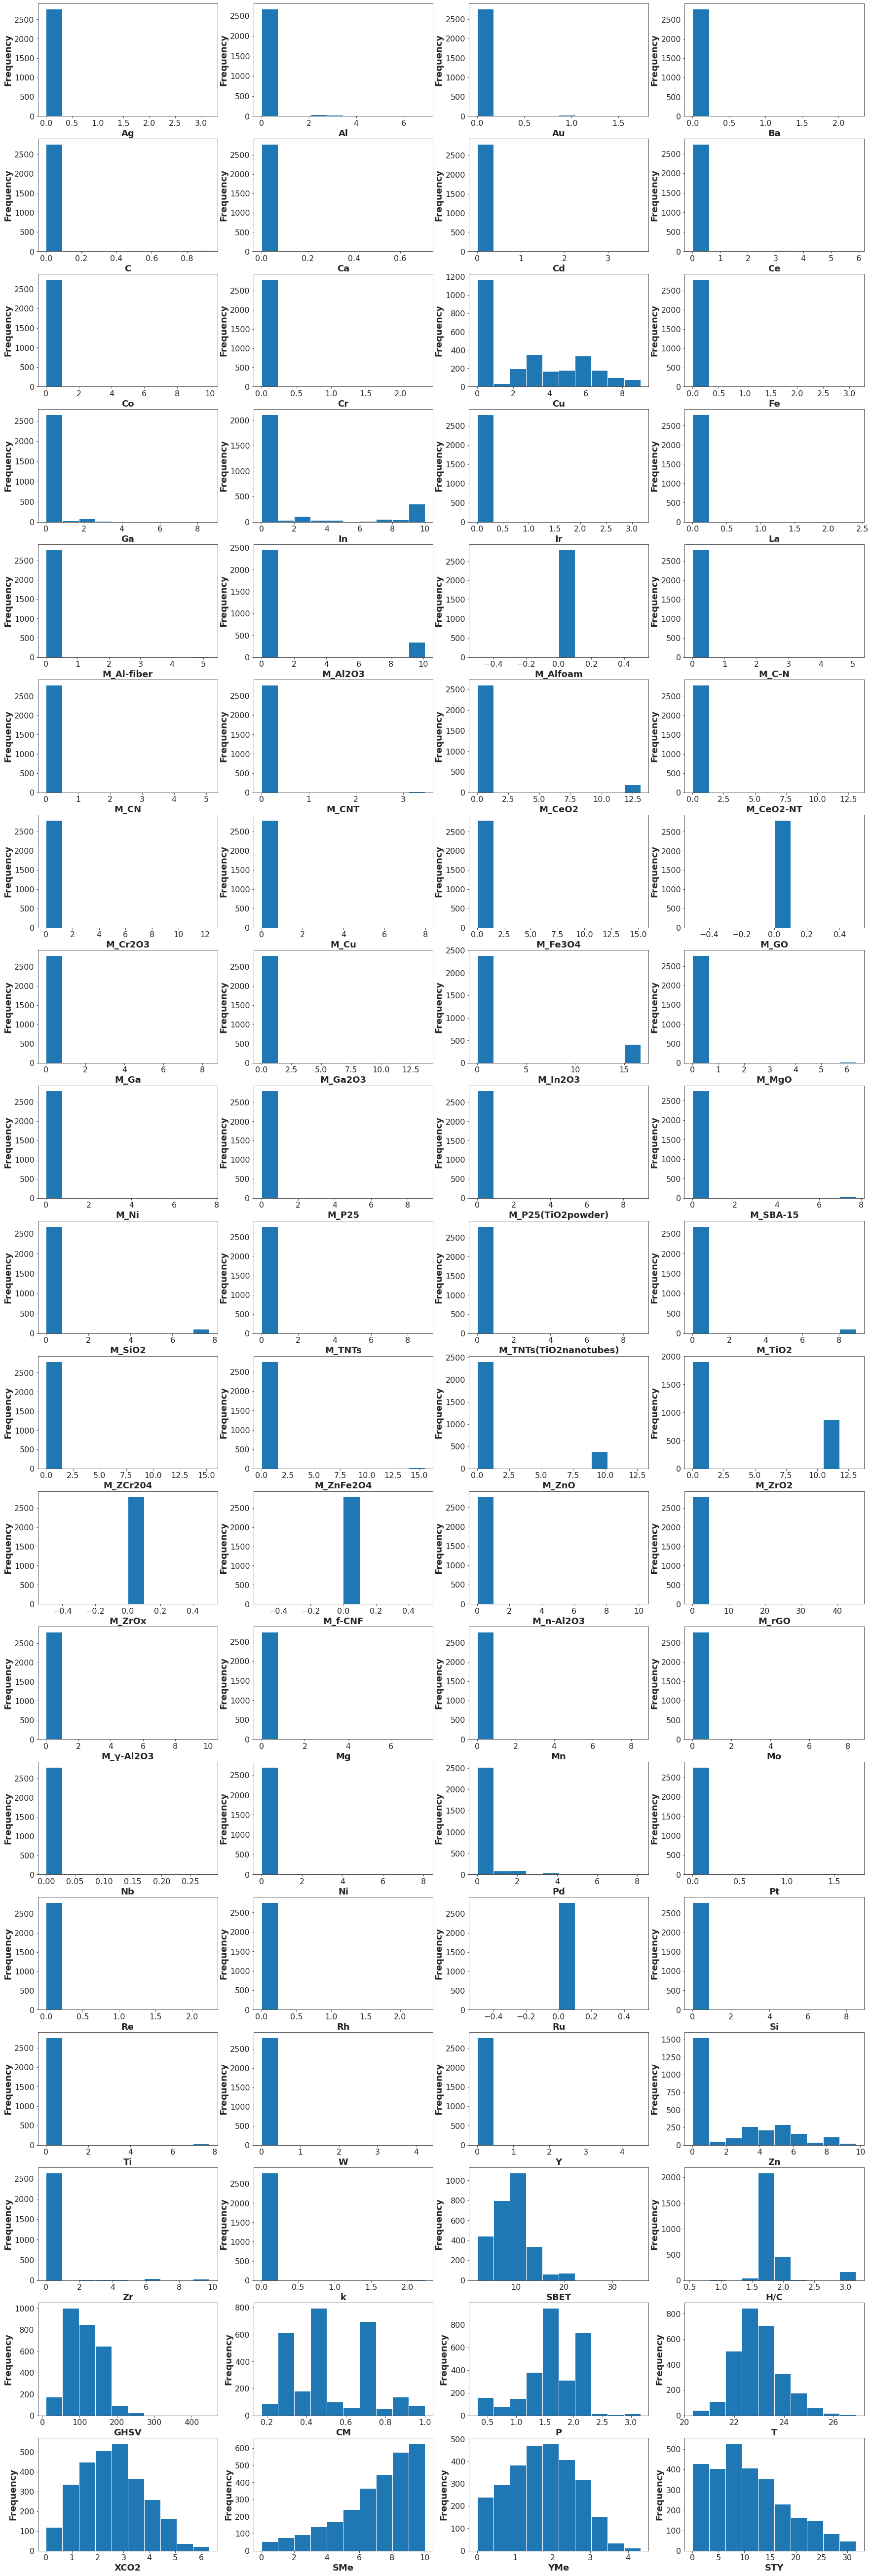

In [275]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df_5tsq:
  sub = fig.add_subplot(20,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df_5tsq[column].plot(kind = 'hist')
  i = i + 1

**A.CUBE TRANSFORMATION**

In [276]:
transformer_cb = FunctionTransformer(np.cbrt)
df_5tcb = transformer_cb.transform(df_Fout5[['Ag', 'Al', 'Au', 'Ba', 'C', 'Ca', 'Cd', 'Ce', 'Co',
       'Cr', 'Cu', 'Fe', 'Ga', 'In', 'Ir', 'La', 'M_Al-fiber', 'M_Al2O3',
       'M_Alfoam', 'M_C-N', 'M_CN', 'M_CNT', 'M_CeO2', 'M_CeO2-NT', 'M_Cr2O3',
       'M_Cu', 'M_Fe3O4', 'M_GO', 'M_Ga', 'M_Ga2O3', 'M_In2O3', 'M_MgO',
       'M_Ni', 'M_P25', 'M_P25(TiO2powder)', 'M_SBA-15', 'M_SiO2', 'M_TNTs',
       'M_TNTs(TiO2nanotubes)', 'M_TiO2', 'M_ZCr204', 'M_ZnFe2O4', 'M_ZnO',
       'M_ZrO2', 'M_ZrOx', 'M_f-CNF', 'M_n-Al2O3', 'M_rGO', 'M_γ-Al2O3', 'Mg',
       'Mn', 'Mo', 'Nb', 'Ni', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 'Si', 'Ti', 'W',
       'Y', 'Zn', 'Zr', 'k', 'SBET', 'H/C', 'GHSV', 'CM', 'P', 'T',
       'XCO2', 'SMe', 'YMe', 'STY']])

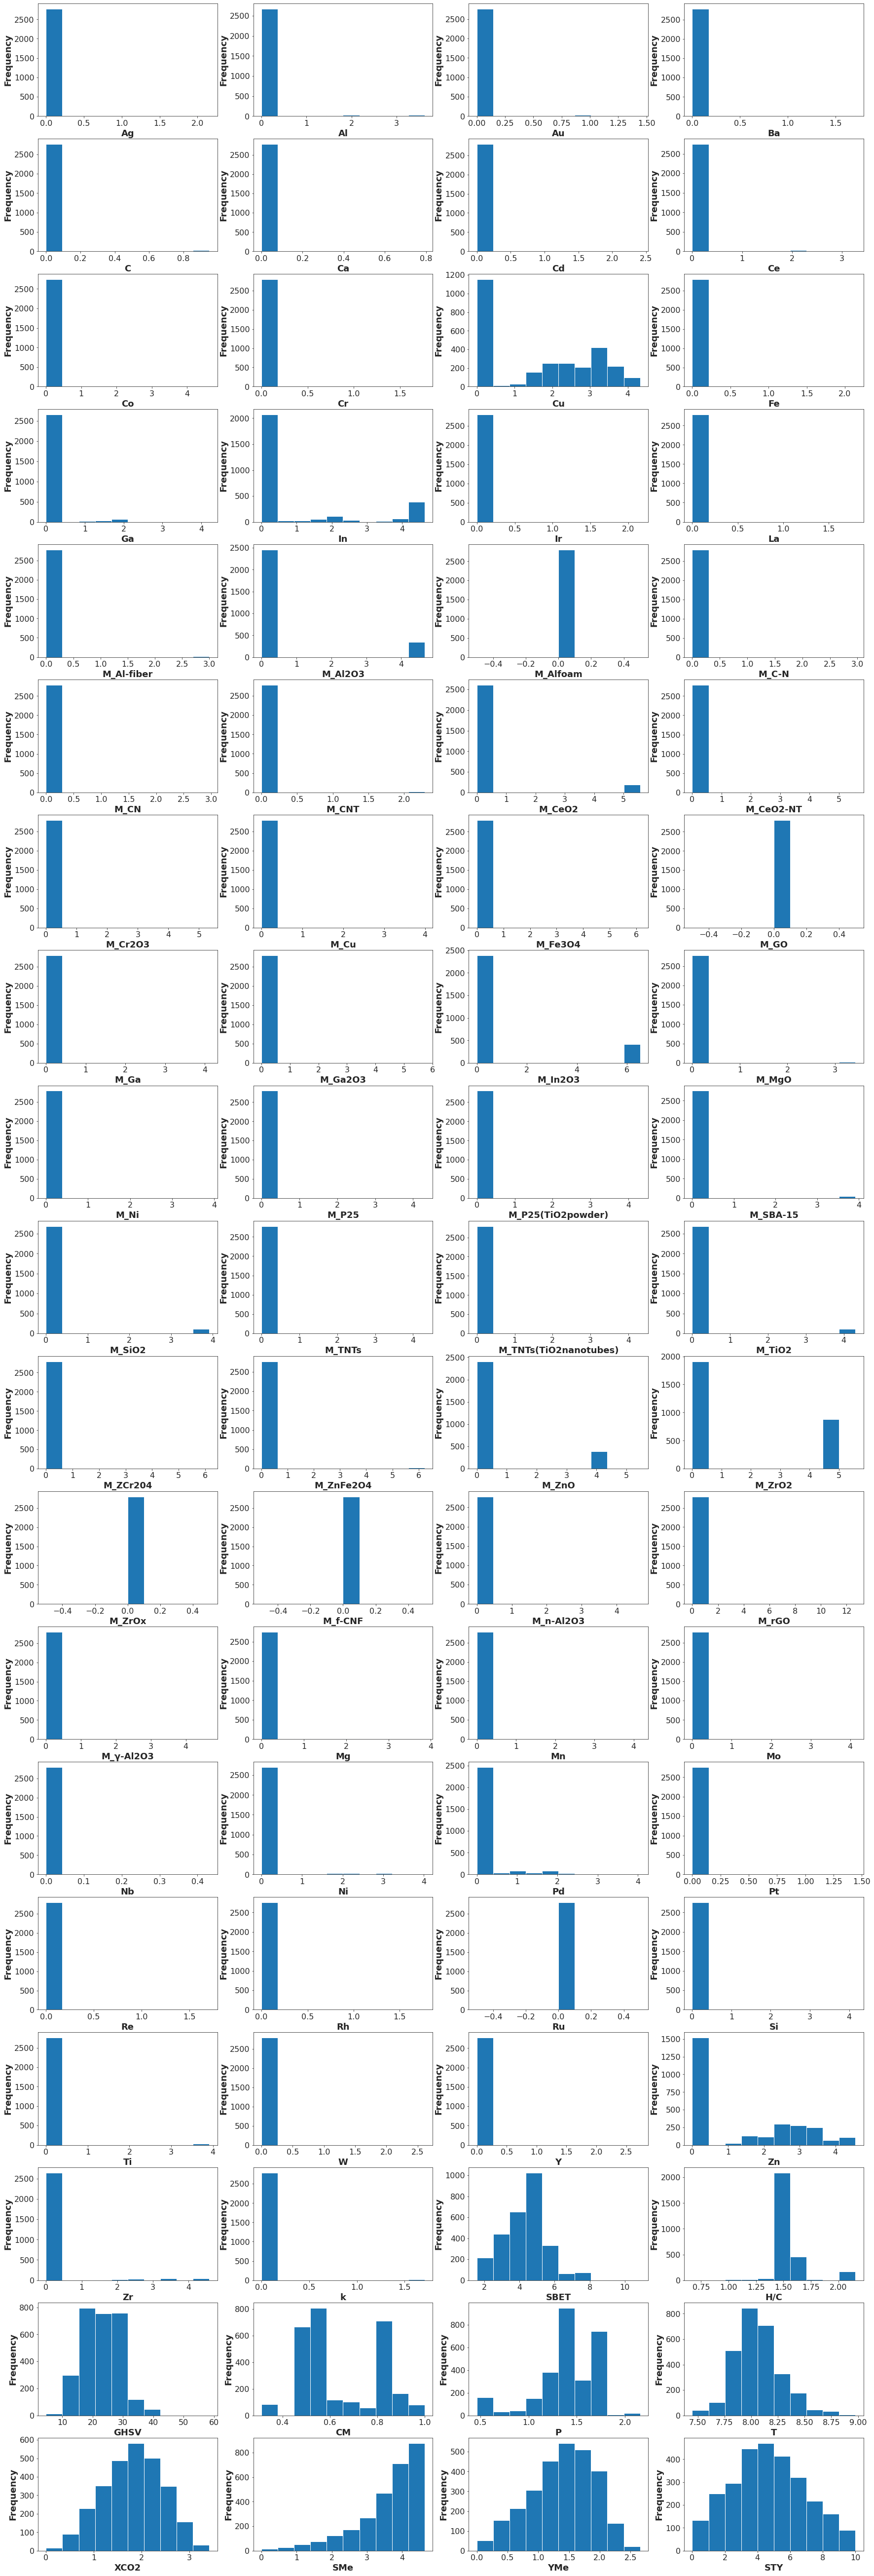

In [277]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df_5tcb:
  sub = fig.add_subplot(20,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df_5tcb[column].plot(kind = 'hist')
  i = i + 1

**B. STATISTICAL APPROACH**



In [278]:
def find_boundaries(df, variable, distance):
  IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
  lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
  upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
  return upper_boundary, lower_boundary

In [279]:
P_upper_limit, P_lower_limit = find_boundaries(df, 'P', 1.5)

In [280]:
outliers_P = np.where(df['P'] > P_upper_limit, True, np.where(df['P'] < P_lower_limit, True,False))

In [281]:
df_soP= df.loc[~(outliers_P)]

In [282]:
XCO2_upper_limit, XCO2_lower_limit = find_boundaries(df_soP, 'XCO2', 1.5)

In [283]:
outliers_XCO2 = np.where(df_soP['XCO2'] > XCO2_upper_limit, True, np.where(df_soP['XCO2'] < XCO2_lower_limit, True,False))

In [284]:
df_soXCO2= df_soP.loc[~(outliers_XCO2)]

In [285]:
YMe_upper_limit, YMe_lower_limit = find_boundaries(df_soXCO2, 'YMe', 1.5)

In [286]:
outliers_YMe = np.where(df_soXCO2['YMe'] > YMe_upper_limit, True, np.where(df_soXCO2['YMe'] < YMe_lower_limit, True,False))

In [287]:
df_soYMe= df_soXCO2.loc[~(outliers_YMe)]

In [288]:
df_soYMe.shape

(2792, 89)

In [289]:
STY_upper_limit, STY_lower_limit = find_boundaries(df_soYMe, 'STY', 1.5)

In [290]:
outliers_STY = np.where(df_soYMe['STY'] > STY_upper_limit, True, np.where(df_soYMe['STY'] < STY_lower_limit, True,False))

In [291]:
df_soSTY= df_soYMe.loc[~(outliers_STY)]

In [292]:
df_soSTY.shape

(2570, 89)

In [293]:
CM_upper_limit, CM_lower_limit = find_boundaries(df_soSTY, 'CM', 1.5)

In [294]:
outliers_CM = np.where(df_soSTY['CM'] > CM_upper_limit, True, np.where(df_soSTY['CM'] < CM_lower_limit, True,False))

In [295]:
df_soCM= df_soSTY.loc[~(outliers_CM)]

In [296]:
df_soCM = df_soCM.drop(columns = ['Pm'])

In [297]:
df_soCM.shape

(2527, 88)

**B.RAW DISTRIBUTION**

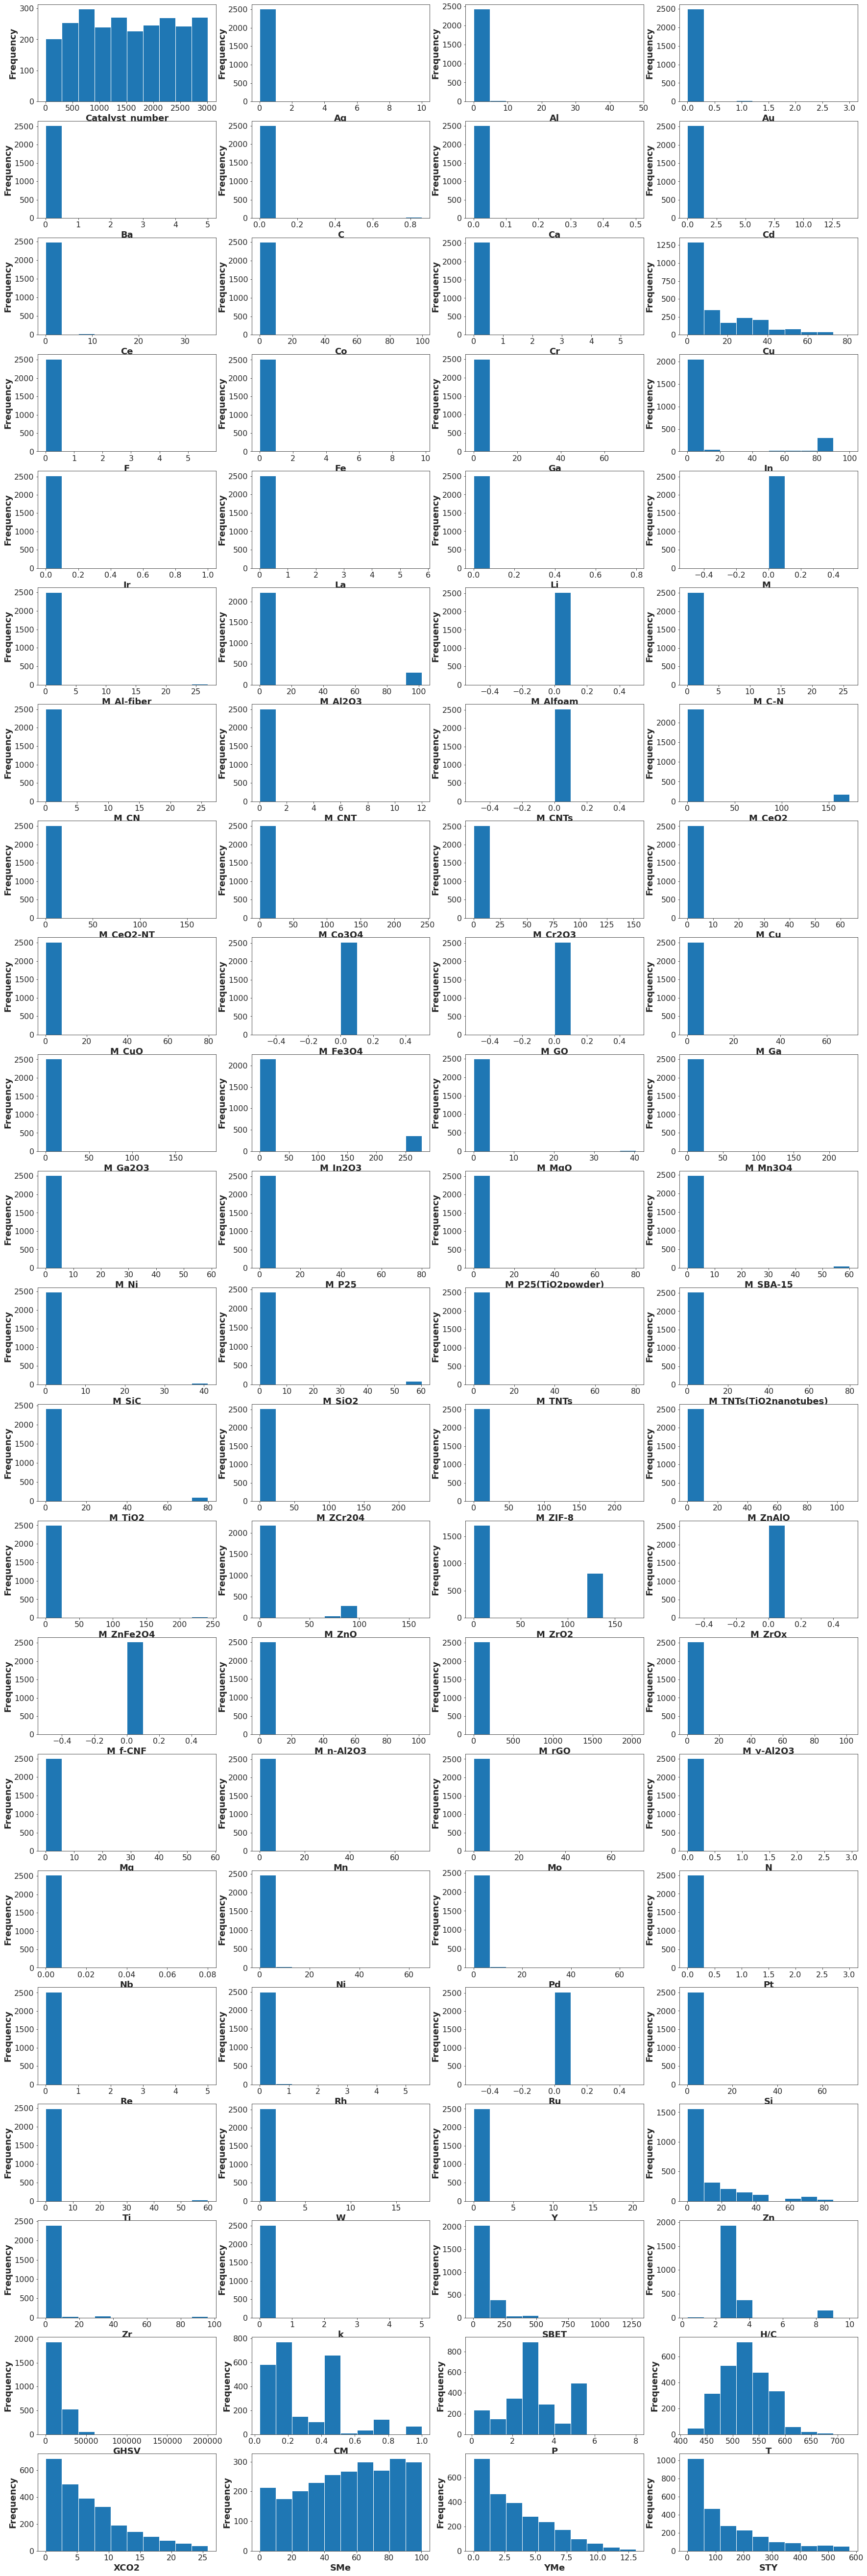

In [298]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df_soCM:
  sub = fig.add_subplot(23,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df_soCM[column].plot(kind = 'hist')
  i = i + 1

 **B.ROOT SQRT TRANSFORMATION**

In [299]:
df_sosq= np.sqrt(df_soCM[['Ag', 'Al', 'Au', 'Ba', 'C', 'Ca', 'Cd', 'Ce', 'Co',
       'Cr', 'Cu', 'Fe', 'Ga', 'In', 'Ir', 'La', 'M_Al-fiber', 'M_Al2O3',
       'M_Alfoam', 'M_C-N', 'M_CN', 'M_CNT', 'M_CeO2', 'M_CeO2-NT', 'M_Cr2O3',
       'M_Cu', 'M_Fe3O4', 'M_GO', 'M_Ga', 'M_Ga2O3', 'M_In2O3', 'M_MgO',
       'M_Ni', 'M_P25', 'M_P25(TiO2powder)', 'M_SBA-15', 'M_SiO2', 'M_TNTs',
       'M_TNTs(TiO2nanotubes)', 'M_TiO2', 'M_ZCr204', 'M_ZnFe2O4', 'M_ZnO',
       'M_ZrO2', 'M_ZrOx', 'M_f-CNF', 'M_n-Al2O3', 'M_rGO', 'M_γ-Al2O3', 'Mg',
       'Mn', 'Mo', 'Nb', 'Ni', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 'Si', 'Ti', 'W',
       'Y', 'Zn', 'Zr', 'k', 'SBET', 'H/C', 'GHSV', 'CM', 'P', 'T',
       'XCO2', 'SMe', 'YMe', 'STY']])

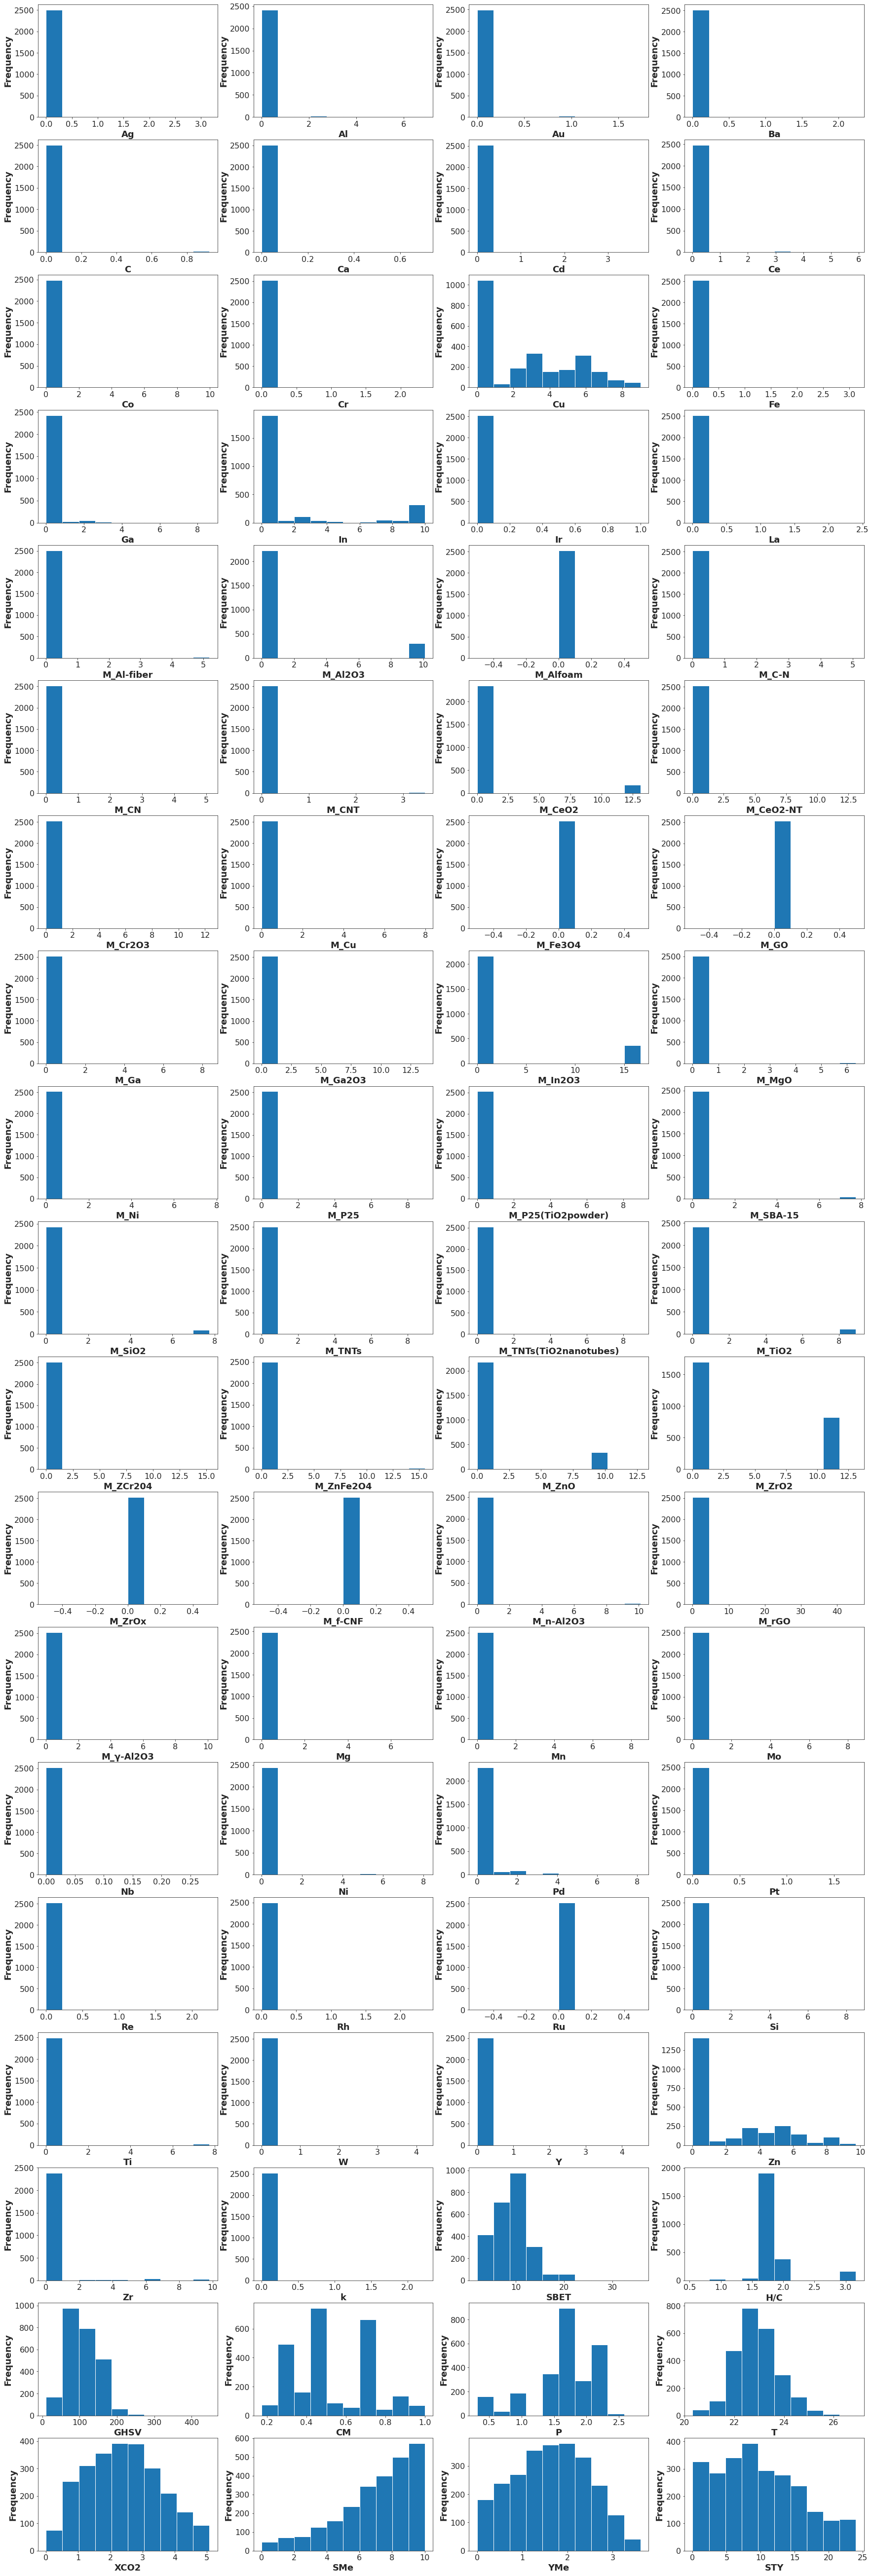

In [300]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df_sosq:
  sub = fig.add_subplot(20,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df_sosq[column].plot(kind = 'hist')
  i = i + 1

 **B.CUBE TRANSFORMATION**

In [301]:
transformer_cb = FunctionTransformer(np.cbrt)
df_socb = transformer_cb.transform(df_soCM[['Ag', 'Al', 'Au', 'Ba', 'C', 'Ca', 'Cd', 'Ce', 'Co',
       'Cr', 'Cu', 'Fe', 'Ga', 'In', 'Ir', 'La', 'M_Al-fiber', 'M_Al2O3',
       'M_Alfoam', 'M_C-N', 'M_CN', 'M_CNT', 'M_CeO2', 'M_CeO2-NT', 'M_Cr2O3',
       'M_Cu', 'M_Fe3O4', 'M_GO', 'M_Ga', 'M_Ga2O3', 'M_In2O3', 'M_MgO',
       'M_Ni', 'M_P25', 'M_P25(TiO2powder)', 'M_SBA-15', 'M_SiO2', 'M_TNTs',
       'M_TNTs(TiO2nanotubes)', 'M_TiO2', 'M_ZCr204', 'M_ZnFe2O4', 'M_ZnO',
       'M_ZrO2', 'M_ZrOx', 'M_f-CNF', 'M_n-Al2O3', 'M_rGO', 'M_γ-Al2O3', 'Mg',
       'Mn', 'Mo', 'Nb', 'Ni', 'Pd', 'Pt', 'Re', 'Rh', 'Ru', 'Si', 'Ti', 'W',
       'Y', 'Zn', 'Zr', 'k', 'SBET', 'H/C', 'GHSV', 'CM', 'P', 'T',
       'XCO2', 'SMe', 'YMe', 'STY']])

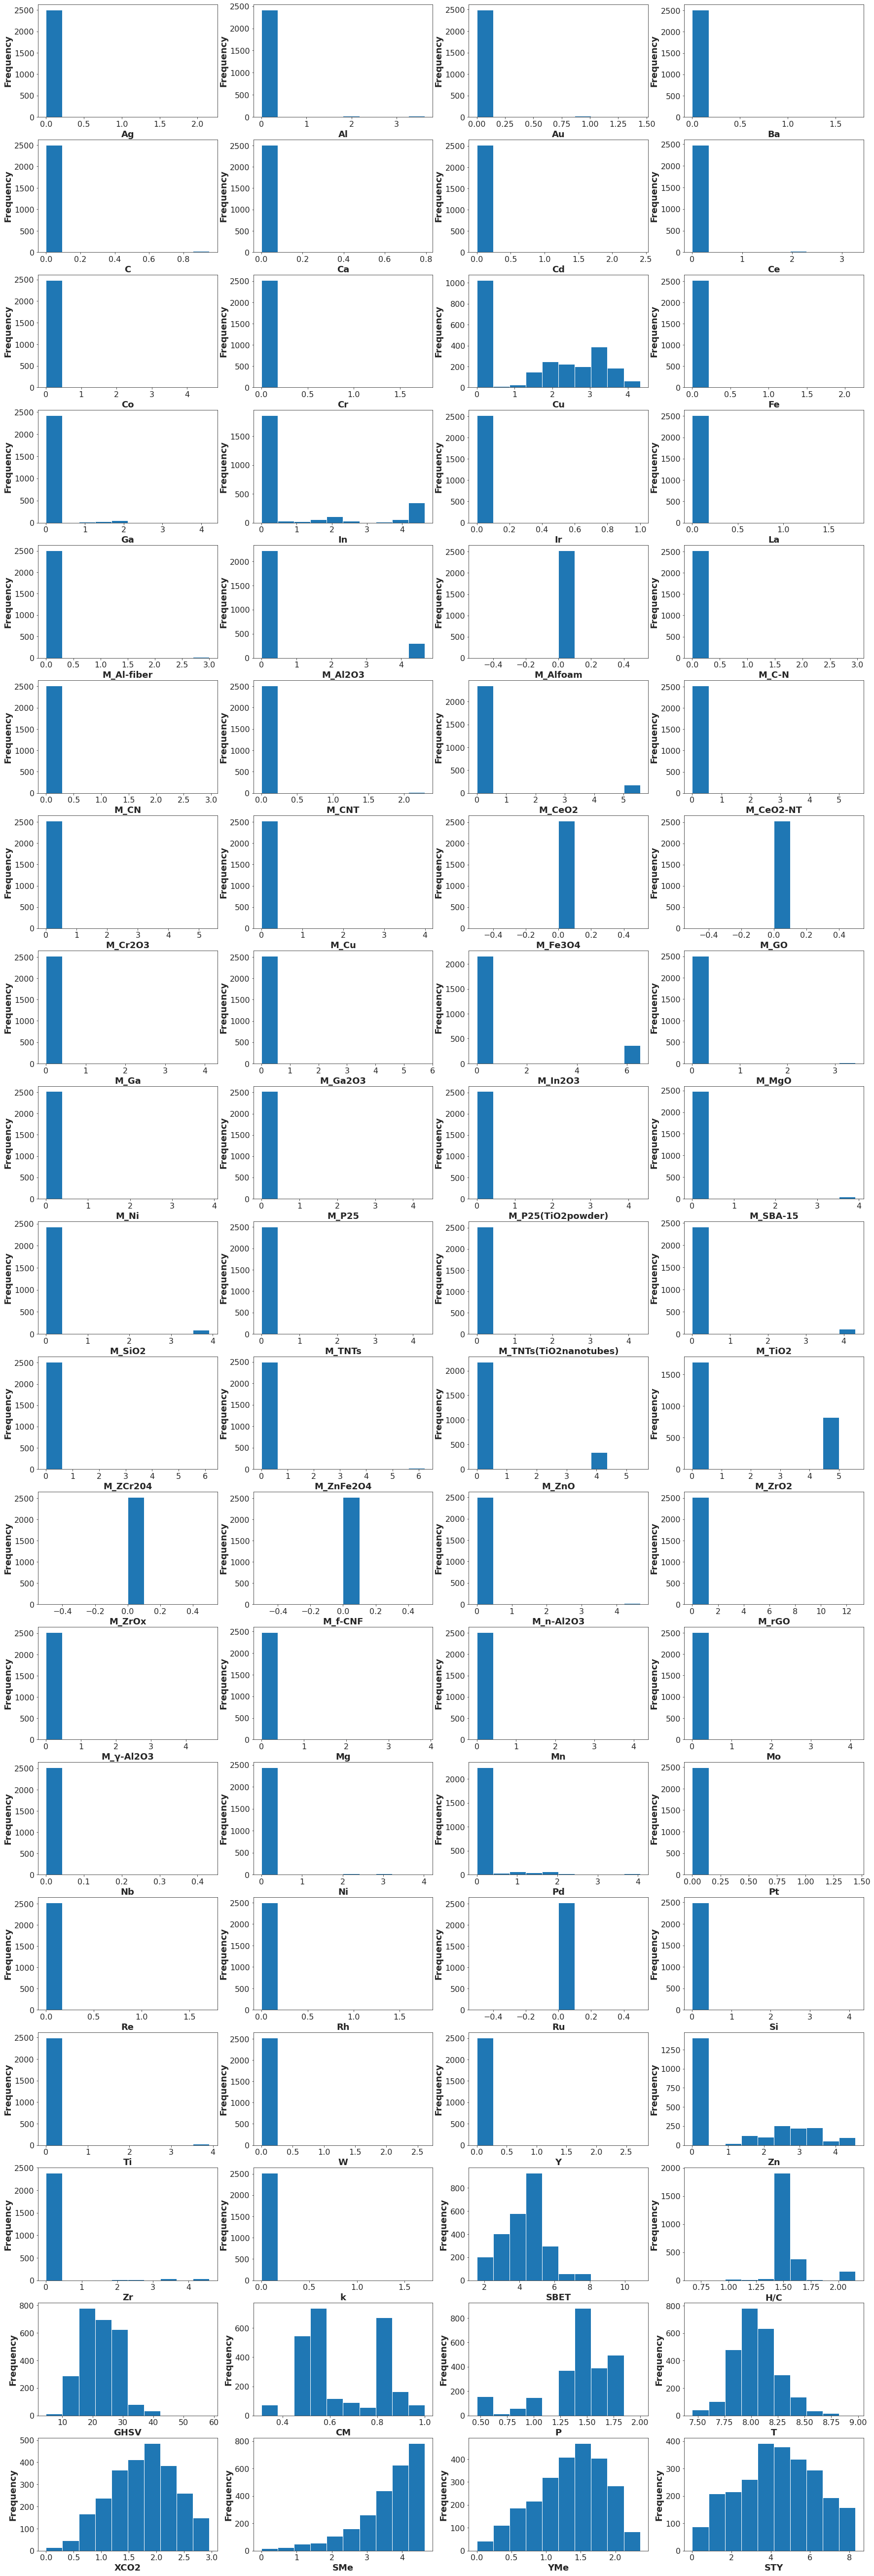

In [302]:
fig = plt.figure(figsize = (30,100))
i = 0
for column in df_socb:
  sub = fig.add_subplot(20,4,i + 1)
  sub.set_xlabel(column,fontsize = 18, fontweight = 'bold')
  sub.set_ylabel('Frequency',fontsize = 18, fontweight = 'bold')
  sub.tick_params(axis='both', labelsize= 16)
  df_socb[column].plot(kind = 'hist')
  i = i + 1

## **Final Data Frame**

In [303]:
df_Fout5.columns


Index(['Catalyst_number', 'Ag', 'Al', 'Au', 'Ba', 'C', 'Ca', 'Cd', 'Ce', 'Co',
       'Cr', 'Cu', 'F', 'Fe', 'Ga', 'In', 'Ir', 'La', 'Li', 'M_', 'M_Al-fiber',
       'M_Al2O3', 'M_Alfoam', 'M_C-N', 'M_CN', 'M_CNT', 'M_CNTs', 'M_CeO2',
       'M_CeO2-NT', 'M_Co3O4', 'M_Cr2O3', 'M_Cu', 'M_CuO', 'M_Fe3O4', 'M_GO',
       'M_Ga', 'M_Ga2O3', 'M_In2O3', 'M_MgO', 'M_Mn3O4', 'M_Ni', 'M_P25',
       'M_P25(TiO2powder)', 'M_SBA-15', 'M_SiC', 'M_SiO2', 'M_TNTs',
       'M_TNTs(TiO2nanotubes)', 'M_TiO2', 'M_ZCr204', 'M_ZIF-8', 'M_ZnAlO',
       'M_ZnFe2O4', 'M_ZnO', 'M_ZrO2', 'M_ZrOx', 'M_f-CNF', 'M_n-Al2O3',
       'M_rGO', 'M_γ-Al2O3', 'Mg', 'Mn', 'Mo', 'N', 'Nb', 'Ni', 'Pd', 'Pt',
       'Re', 'Rh', 'Ru', 'Si', 'Ti', 'W', 'Y', 'Zn', 'Zr', 'k', 'SBET', 'H/C',
       'GHSV', 'CM', 'P', 'T', 'XCO2', 'SMe', 'YMe', 'STY'],
      dtype='object')

In [304]:
 df_FC = df_Fout5.drop(columns = ['SBET', 'H/C','GHSV', 'CM', 'P', 'T', 'XCO2', 'SMe', 'YMe', 'STY'])

In [305]:
df_FR = df_Fout5.loc[:,['T','SMe']]

In [306]:
df_FS = df_5tsq.loc[:,['H/C','GHSV','CM','P']]

In [307]:
df_FCU = df_5tcb.loc[:,['SBET','XCO2','YMe','STY']]

In [308]:
df_flist = [df_FC, df_FR,df_FS,df_FCU]
df_final = pd.concat(df_flist, axis = 1, sort = True)

In [309]:
df_final.head()

Catalyst_number   Ag   Al   Au   Ba    C   Ca   Cd   Ce   Co  ...       T  \
0              1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  453.15   
1              2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  463.15   
2              3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  473.15   
3              4.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  483.15   
4              5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  493.15   

          SMe       H/C       GHSV        CM    P      SBET      XCO2  \
0  100.000000  1.732051  80.625939  0.547723  2.0  4.592377  1.478005   
1   92.957746  1.732051  80.625939  0.547723  2.0  4.592377  1.626755   
2   90.140845  1.732051  80.625939  0.547723  2.0  4.592377  1.781101   
3   81.690141  1.732051  80.625939  0.547723  2.0  4.592377  1.887682   
4   74.178404  1.732051  80.625939  0.547723  2.0  4.592377  2.035250   

        YMe       STY  
0  1.478005  6.006474  
1  1.587635  4.874194  
2  1.720531  4.910290  
3  1.764623  5.036127  
4  1.842370  5.258011  

[5 rows x 88 columns]

# **TRAIN/TEST DATA BASE SPLIT**

In [310]:
X =  df_final.drop(['STY','Catalyst_number','CM','YMe'], axis=1).values

In [311]:
X.shape

(2797, 84)

In [312]:
y=df_final['STY']

In [313]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42, shuffle = True)

# **FEATURE SCALING**

In [314]:
sc = StandardScaler()

In [315]:
X_train_t = sc.fit_transform(X_train)

In [316]:
X_test_t = sc.transform(X_test)

# **MACHINE LEARNING MODELS**

### **XGBoost**

In [317]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.01,
                     max_depth=4, random_state=1,
                     use_label_encoder=False)

In [318]:
model.fit(X_train_t, y_train)

[05:22:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.01, max_depth=4, n_estimators=1000, random_state=1,
             use_label_encoder=False)

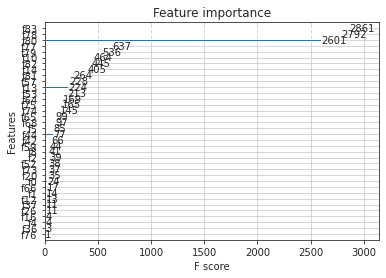

In [319]:
xgb.plot_importance(model, ax=plt.gca())

In [320]:
predicion = model.predict(X_test_t)

In [321]:
#predicion[0:100]
#C=predicion[0:500]
#C.max()
#D = np.array(C)
#np.argmax(D)
#X_test.iloc[24]
#A = X_test.iloc[24]
#A.to_csv('catalizador.csv')
#files.download('catalizador.csv')
#y_test.iloc[24]

In [322]:
predt = model.predict(X_train_t)

In [323]:
print(r2_score(y_train,predt))

0.9778445766635558


In [324]:
model.score(X_test_t,y_test)

0.956679308651549

In [325]:
#k-cross validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = model, X = X_train_t, y= y_train, cv=5)
print("The mean accuracy is: ", accuracies.mean())

[05:22:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:22:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The mean accuracy is:  0.9479159237493446


## **Ramdom forests**


In [326]:
RF =  RandomForestRegressor()
RF.fit(X_train_t, y_train)
#Measure the R2 for training and test set
RF_score = RF.score(X_train_t,y_train)
print("The training R2 is: ", RF.score(X_train_t, y_train))
print("The test R2 is: ", RF.score(X_test_t, y_test))
y_predicted = RF.predict(X_test_t)
y_predicted_train = RF.predict(X_train_t)
# The mean squared error & Variance
print("MSE: %.2f"% mean_squared_error(y_test, y_predicted))
print("RMSE of test set: %.2f"% sqrt(mean_squared_error(y_test, y_predicted)))
print("RMSE of train set: %.2f"% sqrt(mean_squared_error(y_train, y_predicted_train)))
#k-cross validation
accuracies = cross_val_score(estimator = RF, X = X_train, y= y_train, cv=5)
print("The mean accuracy is: ", accuracies.mean())



The training R2 is:  0.9933381914783282
The test R2 is:  0.9522110688920301
MSE: 0.26
RMSE of test set: 0.51
RMSE of train set: 0.18
The mean accuracy is:  0.945730029042285


**Neural Networks**

In [327]:
X_train.shape

(1957, 84)

In [328]:
X_train.shape[1]

84

In [329]:
# Guardar la cantidad de características que tenemos como nuestra forma de entrada
input_shape = X_train.shape[1]
input_shape

84

In [330]:
# Modelo secuencial
model = Sequential()

In [331]:
# Dense layers
model.add(Dense(12,  input_dim = input_shape, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'relu'))

In [332]:
def rmse(y_true, y_pred):
  return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
model.compile(optimizer = 'rmsprop', loss = 'mse')

In [333]:
history = model.fit(X_train, y_train,validation_data = (X_test, y_test), epochs=100)

Epoch 1/100
62/62 [==============================] - 1s 4ms/step - loss: 1204.3335 - val_loss: 268.2261
Epoch 2/100
62/62 [==============================] - 0s 2ms/step - loss: 112.6857 - val_loss: 235.7038
Epoch 3/100
62/62 [==============================] - 0s 2ms/step - loss: 224.9090 - val_loss: 172.2383
Epoch 4/100
62/62 [==============================] - 0s 3ms/step - loss: 106.6998 - val_loss: 127.6045
Epoch 5/100
62/62 [==============================] - 0s 3ms/step - loss: 75.0333 - val_loss: 99.1143
Epoch 6/100
62/62 [==============================] - 0s 3ms/step - loss: 52.6867 - val_loss: 74.2202
Epoch 7/100
62/62 [==============================] - 0s 3ms/step - loss: 30.8118 - val_loss: 62.3822
Epoch 8/100
62/62 [==============================] - 0s 2ms/step - loss: 46.1107 - val_loss: 50.7130
Epoch 9/100
62/62 [==============================] - 0s 3ms/step - loss: 24.3523 - val_loss: 54.0271
Epoch 10/100
62/62 [==============================] - 0s 3ms/step - loss: 25.9786 

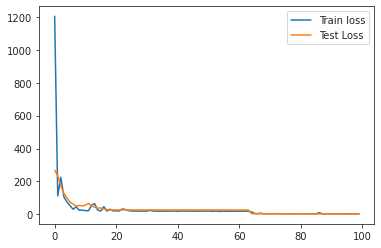

In [334]:
# Visualizar la pérdida
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

In [335]:
y_pred_nn = model.predict(X_test)

27/27 [==============================] - 0s 1ms/step


In [336]:
r2_score(y_test, y_pred_nn)

0.3985514919431674

## **k-Nearest neighbors**

In [337]:

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(kms, precio)

kms_instancia = escala_kms.transform([[20000]])
precio_instancia = knn.predict(kms_instancia)
escala_precio.inverse_transform(precio_instancia)

NameError: ignored

## **Supporting vector machines**